In [8]:
"""
Glass-Box Transformer: A Fully Interpretable Language Model
Built with explicit interpretability at every layer
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

class InterpretableAttention(nn.Module):
    """
    Attention mechanism with explicit interpretability.
    Each head has a semantic purpose that we can inspect.
    """
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        # Separate projections for interpretability
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

        # Head names for interpretability
        self.head_names = [f"Head_{i}" for i in range(n_heads)]

    def forward(self, x: torch.Tensor, mask=None) -> Tuple[torch.Tensor, Dict]:
        batch_size, seq_len, _ = x.shape

        # Project and split into heads
        Q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        K = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)

        # Attention scores
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.head_dim)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)

        # Apply attention
        attn_output = torch.matmul(attn_weights, V)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.o_proj(attn_output)

        # Store interpretability info
        interpretability = {
            'attention_weights': attn_weights.detach(),
            'head_names': self.head_names
        }

        return output, interpretability


class InterpretableFFN(nn.Module):
    """
    Feed-forward network with explicit feature interpretability.
    We can see which neurons activate for which patterns.
    """
    def __init__(self, d_model: int, d_ff: int):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.GELU()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, Dict]:
        # First layer with activation
        hidden = self.activation(self.linear1(x))
        output = self.linear2(hidden)

        # Store interpretability info
        interpretability = {
            'hidden_activations': hidden.detach(),
            'neuron_importance': hidden.abs().mean(dim=(0, 1)).detach()
        }

        return output, interpretability


class GlassBoxTransformerLayer(nn.Module):
    """
    Single transformer layer with full interpretability tracking.
    """
    def __init__(self, d_model: int, n_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.attention = InterpretableAttention(d_model, n_heads)
        self.ffn = InterpretableFFN(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask=None) -> Tuple[torch.Tensor, Dict]:
        # Attention block with residual
        attn_out, attn_interp = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attn_out)

        # FFN block with residual
        ffn_out, ffn_interp = self.ffn(self.norm2(x))
        x = x + self.dropout(ffn_out)

        # Combine interpretability info
        interpretability = {
            'attention': attn_interp,
            'ffn': ffn_interp,
            'residual_contribution': {
                'attention': attn_out.abs().mean().item(),
                'ffn': ffn_out.abs().mean().item()
            }
        }

        return x, interpretability


class ContextAwareGlassBoxTransformer(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 128,
        n_layers: int = 4,
        n_heads: int = 4,
        d_ff: int = 512,
        max_seq_len: int = 512,
        dropout: float = 0.1,
        tokenizer=None,  # CRITICAL: Must pass tokenizer
        use_context_features: bool = True  # Toggle context features
    ):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.tokenizer = tokenizer
        self.use_context_features = use_context_features

        # Contextual embeddings instead of static
        if use_context_features:
            self.token_embedding = ContextualEmbedding(vocab_size, d_model, context_window=3)

            # Semantic role layer (only if tokenizer provided)
            if tokenizer is not None:
                self.semantic_layer = SemanticRoleAttention(d_model, vocab_size)
            else:
                self.semantic_layer = None
                print("⚠️  Warning: No tokenizer provided, semantic roles disabled")

            # Adaptive rule layer
            self.rule_layer = AdaptiveRuleLayer(d_model, max_rules=100)
        else:
            # Fallback to standard embedding
            self.token_embedding = nn.Embedding(vocab_size, d_model)
            self.semantic_layer = None
            self.rule_layer = None

        self.position_embedding = nn.Embedding(max_seq_len, d_model)

        # Regular transformer layers
        self.layers = nn.ModuleList([
            GlassBoxTransformerLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        # Output projection
        self.output_norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask=None) -> Tuple[torch.Tensor, Dict]:
        batch_size, seq_len = x.shape

        # Contextual embeddings
        if self.use_context_features and isinstance(self.token_embedding, ContextualEmbedding):
            token_emb, emb_interp = self.token_embedding(x)
        else:
            token_emb = self.token_embedding(x)
            emb_interp = {}

        # Position embeddings
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pos_emb = self.position_embedding(positions)

        hidden = self.dropout(token_emb + pos_emb)

        # Apply semantic role analysis (if available)
        semantic_interp = {}
        if self.semantic_layer is not None and self.tokenizer is not None:
            hidden, semantic_interp = self.semantic_layer(hidden, x, self.tokenizer)

        # Apply adaptive rules (if available)
        rule_interp = {}
        if self.rule_layer is not None:
            hidden, rule_interp = self.rule_layer(hidden)

        # Regular transformer layers
        layer_interpretability = []
        for i, layer in enumerate(self.layers):
            hidden, interp = layer(hidden, mask)
            interp['layer_idx'] = i
            layer_interpretability.append(interp)

        # Output
        hidden = self.output_norm(hidden)
        logits = self.output_proj(hidden)

        # Complete interpretability package
        full_interpretability = {
            'contextual_embeddings': emb_interp,
            'semantic_roles': semantic_interp,
            'rules': rule_interp,
            'layers': layer_interpretability,
            'final_hidden': hidden.detach()
        }

        return logits, full_interpretability

class GlassBoxVisualizer:
    """
    Visualization tools for understanding the glass-box transformer.
    """
    @staticmethod
    def plot_attention_pattern(attn_weights: np.ndarray, tokens: List[str] = None):
        """Plot attention patterns for all heads."""
        n_heads = attn_weights.shape[0]
        fig, axes = plt.subplots(1, n_heads, figsize=(4*n_heads, 4))

        if n_heads == 1:
            axes = [axes]

        for head_idx, ax in enumerate(axes):
            sns.heatmap(attn_weights[head_idx], ax=ax, cmap='YlOrRd',
                       xticklabels=tokens, yticklabels=tokens)
            ax.set_title(f'Head {head_idx}')

        plt.tight_layout()
        return fig

    @staticmethod
    def plot_layer_contributions(interpretability: Dict):
        """Plot how much each layer contributes."""
        layers = []
        attn_contrib = []
        ffn_contrib = []

        for layer_info in interpretability['layers']:
            layers.append(layer_info['layer_idx'])
            contrib = layer_info['residual_contribution']
            attn_contrib.append(contrib['attention'])
            ffn_contrib.append(contrib['ffn'])

        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(layers))
        width = 0.35

        ax.bar(x - width/2, attn_contrib, width, label='Attention')
        ax.bar(x + width/2, ffn_contrib, width, label='FFN')

        ax.set_xlabel('Layer')
        ax.set_ylabel('Average Contribution')
        ax.set_title('Layer-wise Contributions to Output')
        ax.set_xticks(x)
        ax.set_xticklabels([f'Layer {i}' for i in layers])
        ax.legend()

        plt.tight_layout()
        return fig


# =============================================================================
# CELL 1: Test the Model Architecture
# =============================================================================
def test_architecture():
    print("🔍 Glass-Box Transformer Initialized")
    print("=" * 50)

    # Create a small model
    vocab_size = 1000
    model = GlassBoxTransformer(
        vocab_size=vocab_size,
        d_model=128,
        n_layers=4,
        n_heads=4,
        d_ff=512,
        max_seq_len=128
    )

    # Count parameters
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Model Parameters: {n_params:,}")
    print(f"Model Size: ~{n_params * 4 / 1024 / 1024:.2f} MB (FP32)")

    # Test forward pass
    batch_size = 2
    seq_len = 10
    dummy_input = torch.randint(0, vocab_size, (batch_size, seq_len))

    print(f"\nTest Input Shape: {dummy_input.shape}")

    with torch.no_grad():
        logits, interpretability = model(dummy_input)

    print(f"Output Shape: {logits.shape}")
    print(f"\nInterpretability Package Contains:")
    print(f"  - {len(interpretability['layers'])} layer explanations")
    print(f"  - Token embeddings: {interpretability['token_embeddings'].shape}")
    print(f"  - Position embeddings: {interpretability['position_embeddings'].shape}")
    print(f"  - Final hidden states: {interpretability['final_hidden'].shape}")

    print("\n✅ Glass-Box Transformer Ready!")
    return model

In [11]:
# =============================================================================
# CELL 2: COMPREHENSIVE DOMAIN-SPECIFIC TOKENIZER
# =============================================================================
class ComprehensiveChurnTokenizer:
    """
    Enterprise-grade tokenizer with domain-specific vocabulary.
    Organized by linguistic and semantic categories for interpretability.
    """
    def __init__(self):
        # =============================================================================
        # SENTIMENT & EMOTION WORDS
        # =============================================================================

        # Strong positive sentiment
        strong_positive = [
            'amazing', 'awesome', 'excellent', 'outstanding', 'exceptional', 'phenomenal',
            'spectacular', 'superb', 'wonderful', 'fantastic', 'brilliant', 'magnificent',
            'marvelous', 'fabulous', 'terrific', 'stellar', 'supreme', 'unbeatable',
            'extraordinary', 'remarkable', 'impressive', 'stunning', 'dazzling'
        ]

        # Moderate positive sentiment
        moderate_positive = [
            'good', 'great', 'nice', 'fine', 'pleasant', 'positive', 'satisfactory',
            'acceptable', 'decent', 'solid', 'adequate', 'reasonable', 'fair',
            'delightful', 'enjoyable', 'lovely', 'sweet', 'pretty', 'favorable'
        ]

        # Weak positive sentiment
        weak_positive = [
            'okay', 'ok', 'alright', 'passable', 'tolerable', 'bearable', 'manageable'
        ]

        # Strong negative sentiment
        strong_negative = [
            'terrible', 'horrible', 'awful', 'atrocious', 'abysmal', 'dreadful',
            'appalling', 'horrendous', 'deplorable', 'disastrous', 'catastrophic',
            'nightmarish', 'unbearable', 'intolerable', 'unacceptable', 'abominable',
            'pathetic', 'miserable', 'wretched', 'despicable', 'detestable'
        ]

        # Moderate negative sentiment
        moderate_negative = [
            'bad', 'poor', 'subpar', 'inferior', 'inadequate', 'unsatisfactory',
            'disappointing', 'unfortunate', 'regrettable', 'unpleasant', 'negative',
            'problematic', 'troublesome', 'deficient', 'lacking', 'weak'
        ]

        # Weak negative sentiment
        weak_negative = [
            'mediocre', 'average', 'ordinary', 'unremarkable', 'forgettable', 'bland',
            'boring', 'dull', 'tedious', 'monotonous'
        ]

        # Emotional states
        emotions = [
            'happy', 'sad', 'angry', 'frustrated', 'annoyed', 'irritated', 'furious',
            'pleased', 'satisfied', 'content', 'delighted', 'thrilled', 'excited',
            'disappointed', 'upset', 'distressed', 'concerned', 'worried', 'anxious',
            'confused', 'surprised', 'shocked', 'amazed', 'grateful', 'thankful',
            'relieved', 'hopeful', 'optimistic', 'pessimistic', 'discouraged'
        ]

        # =============================================================================
        # INTENSITY MODIFIERS (ADVERBS)
        # =============================================================================

        # Amplifiers (intensify sentiment)
        amplifiers = [
            'very', 'extremely', 'incredibly', 'absolutely', 'completely', 'totally',
            'utterly', 'thoroughly', 'entirely', 'fully', 'highly', 'remarkably',
            'exceptionally', 'extraordinarily', 'particularly', 'especially', 'truly',
            'genuinely', 'really', 'seriously', 'desperately', 'severely', 'deeply',
            'profoundly', 'intensely', 'immensely', 'tremendously', 'enormously'
        ]

        # Diminishers (reduce sentiment)
        diminishers = [
            'slightly', 'somewhat', 'fairly', 'rather', 'quite', 'pretty',
            'relatively', 'moderately', 'reasonably', 'partially', 'partly',
            'barely', 'hardly', 'scarcely', 'marginally', 'minimally', 'nominally'
        ]

        # Frequency adverbs
        frequency = [
            'always', 'constantly', 'continually', 'frequently', 'often', 'regularly',
            'usually', 'normally', 'typically', 'generally', 'commonly', 'sometimes',
            'occasionally', 'rarely', 'seldom', 'never', 'hardly ever', 'repeatedly',
            'consistently', 'persistently', 'routinely'
        ]

        # Temporal adverbs
        temporal = [
            'now', 'currently', 'presently', 'today', 'recently', 'lately', 'yesterday',
            'previously', 'formerly', 'earlier', 'soon', 'immediately', 'instantly',
            'quickly', 'rapidly', 'swiftly', 'slowly', 'gradually', 'eventually',
            'finally', 'ultimately', 'already', 'still', 'yet', 'anymore'
        ]

        # =============================================================================
        # NEGATION & CONTRAST
        # =============================================================================

        # Negation words
        negations = [
            'not', 'no', 'never', 'neither', 'nobody', 'nothing', 'nowhere',
            'none', "n't", "won't", "can't", "don't", "doesn't", "didn't",
            "hasn't", "haven't", "hadn't", "isn't", "aren't", "wasn't", "weren't",
            "wouldn't", "shouldn't", "couldn't", "mightn't", "mustn't"
        ]

        # Contrast/adversative conjunctions
        contrast_words = [
            'but', 'however', 'although', 'though', 'yet', 'nevertheless',
            'nonetheless', 'whereas', 'while', 'despite', 'except', 'unfortunately',
            'sadly', 'regrettably', 'conversely', 'instead', 'rather', 'alternatively'
        ]

        # =============================================================================
        # CUSTOMER SERVICE & EXPERIENCE VOCABULARY
        # =============================================================================

        # Service quality descriptors
        service_quality = [
            'service', 'support', 'assistance', 'help', 'care', 'attention',
            'response', 'resolution', 'solution', 'handling', 'treatment',
            'professionalism', 'courtesy', 'politeness', 'friendliness', 'helpfulness',
            'efficiency', 'effectiveness', 'competence', 'expertise', 'knowledge',
            'responsiveness', 'availability', 'accessibility', 'reliability'
        ]

        # Customer experience terms
        experience_terms = [
            'experience', 'interaction', 'engagement', 'encounter', 'visit',
            'journey', 'process', 'procedure', 'transaction', 'communication',
            'correspondence', 'conversation', 'discussion', 'consultation', 'meeting'
        ]

        # Problem/issue terminology
        problems = [
            'problem', 'issue', 'trouble', 'difficulty', 'challenge', 'concern',
            'complaint', 'grievance', 'dispute', 'conflict', 'matter', 'situation',
            'complication', 'obstacle', 'hindrance', 'impediment', 'setback',
            'malfunction', 'failure', 'error', 'mistake', 'bug', 'glitch',
            'defect', 'flaw', 'fault', 'breakdown', 'outage', 'disruption'
        ]

        # =============================================================================
        # TELCO/TELECOM SPECIFIC VOCABULARY
        # =============================================================================

        # Network & connectivity
        network_terms = [
            'network', 'connection', 'connectivity', 'signal', 'coverage', 'reception',
            'bandwidth', 'speed', 'latency', 'lag', 'delay', 'buffering',
            'streaming', 'download', 'upload', 'throughput', 'quality',
            'stability', 'reliability', 'availability', 'uptime', 'downtime',
            'outage', 'interruption', 'disruption', 'interference'
        ]

        # Service types
        telco_services = [
            'phone', 'mobile', 'cellular', 'landline', 'telephone', 'call', 'calling',
            'internet', 'broadband', 'wifi', 'wireless', 'data', 'roaming',
            'voicemail', 'text', 'messaging', 'sms', 'mms', 'email',
            'tv', 'television', 'cable', 'satellite', 'streaming', 'video',
            'bundle', 'package', 'plan', 'subscription', 'contract', 'agreement'
        ]

        # Technical issues
        technical_issues = [
            'dropped', 'disconnected', 'lost', 'dead', 'frozen', 'stuck',
            'slow', 'sluggish', 'intermittent', 'unstable', 'unreliable',
            'spotty', 'patchy', 'inconsistent', 'degraded', 'throttled',
            'blocked', 'restricted', 'limited', 'capped', 'overcharged'
        ]

        # =============================================================================
        # BILLING & PRICING VOCABULARY
        # =============================================================================

        # Financial terms
        billing_terms = [
            'bill', 'billing', 'charge', 'charges', 'fee', 'fees', 'cost', 'costs',
            'price', 'pricing', 'rate', 'rates', 'payment', 'invoice', 'statement',
            'balance', 'amount', 'total', 'subtotal', 'tax', 'taxes',
            'discount', 'promotion', 'offer', 'deal', 'rebate', 'refund',
            'credit', 'debit', 'overcharge', 'undercharge', 'adjustment'
        ]

        # Value perception
        value_terms = [
            'value', 'worth', 'worthwhile', 'affordable', 'expensive', 'cheap',
            'costly', 'pricey', 'overpriced', 'underpriced', 'reasonable', 'fair',
            'unfair', 'excessive', 'exorbitant', 'competitive', 'economical',
            'budget', 'premium', 'luxury', 'standard', 'basic'
        ]

        # =============================================================================
        # CUSTOMER ACTIONS & INTENTIONS
        # =============================================================================

        # Churn signals (HIGH PRIORITY)
        churn_signals = [
            'cancel', 'canceling', 'cancelled', 'cancellation', 'terminate',
            'terminating', 'terminated', 'termination', 'discontinue', 'disconnect',
            'leave', 'leaving', 'left', 'quit', 'quitting', 'switch', 'switching',
            'switched', 'change', 'changing', 'changed', 'move', 'moving', 'moved',
            'transfer', 'transferring', 'end', 'ending', 'ended', 'stop', 'stopping',
            'stopped', 'drop', 'dropping', 'dropped'
        ]

        # Retention signals
        retention_signals = [
            'stay', 'staying', 'stayed', 'remain', 'remaining', 'remained',
            'continue', 'continuing', 'continued', 'renew', 'renewing', 'renewed',
            'extend', 'extending', 'extended', 'upgrade', 'upgrading', 'upgraded',
            'keep', 'keeping', 'kept', 'retain', 'retaining', 'retained'
        ]

        # Contact/engagement actions
        engagement_actions = [
            'contact', 'contacted', 'contacting', 'call', 'called', 'calling',
            'email', 'emailed', 'emailing', 'message', 'messaged', 'messaging',
            'chat', 'chatted', 'chatting', 'speak', 'spoke', 'spoken', 'speaking',
            'talk', 'talked', 'talking', 'reach', 'reached', 'reaching',
            'report', 'reported', 'reporting', 'complain', 'complained', 'complaining',
            'request', 'requested', 'requesting', 'ask', 'asked', 'asking'
        ]

        # =============================================================================
        # COMPARISON & COMPETITOR VOCABULARY
        # =============================================================================

        # Competitor mentions
        competitor_terms = [
            'competitor', 'competition', 'rival', 'alternative', 'option',
            'other', 'another', 'different', 'elsewhere', 'switch', 'compare',
            'comparison', 'versus', 'vs', 'better', 'worse', 'superior',
            'inferior', 'prefer', 'preference', 'choice'
        ]

        # =============================================================================
        # TEMPORAL EXPRESSIONS
        # =============================================================================

        # Duration
        duration_terms = [
            'second', 'seconds', 'minute', 'minutes', 'hour', 'hours',
            'day', 'days', 'week', 'weeks', 'month', 'months', 'year', 'years',
            'long', 'short', 'brief', 'extended', 'prolonged', 'temporary',
            'permanent', 'ongoing', 'continuous'
        ]

        # Time references
        time_references = [
            'ago', 'since', 'until', 'till', 'from', 'to', 'between',
            'during', 'within', 'after', 'before', 'past', 'future',
            'present', 'current', 'previous', 'next', 'last', 'first'
        ]

        # =============================================================================
        # STANDARD LINGUISTIC CATEGORIES
        # =============================================================================

        # Common verbs
        common_verbs = [
            'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being',
            'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
            'make', 'makes', 'made', 'making', 'get', 'gets', 'got', 'getting',
            'go', 'goes', 'went', 'going', 'gone', 'come', 'comes', 'came', 'coming',
            'take', 'takes', 'took', 'taking', 'taken', 'see', 'sees', 'saw', 'seeing', 'seen',
            'know', 'knows', 'knew', 'knowing', 'known', 'think', 'thinks', 'thought', 'thinking',
            'give', 'gives', 'gave', 'giving', 'given', 'find', 'finds', 'found', 'finding',
            'tell', 'tells', 'told', 'telling', 'become', 'becomes', 'became', 'becoming',
            'show', 'shows', 'showed', 'showing', 'shown', 'let', 'lets', 'letting',
            'begin', 'begins', 'began', 'beginning', 'begun', 'seem', 'seems', 'seemed', 'seeming',
            'help', 'helps', 'helped', 'helping', 'try', 'tries', 'tried', 'trying',
            'use', 'uses', 'used', 'using', 'need', 'needs', 'needed', 'needing',
            'want', 'wants', 'wanted', 'wanting', 'work', 'works', 'worked', 'working',
            'feel', 'feels', 'felt', 'feeling', 'become', 'becomes', 'became', 'becoming',
            'provide', 'provides', 'provided', 'providing', 'lose', 'loses', 'lost', 'losing',
            'pay', 'pays', 'paid', 'paying', 'meet', 'meets', 'met', 'meeting',
            'include', 'includes', 'included', 'including', 'continue', 'continues', 'continued',
            'set', 'sets', 'setting', 'learn', 'learns', 'learned', 'learning',
            'add', 'adds', 'added', 'adding', 'understand', 'understands', 'understood', 'understanding'
        ]

        # Common nouns
        common_nouns = [
            'time', 'person', 'people', 'year', 'way', 'day', 'thing', 'man', 'woman',
            'world', 'life', 'hand', 'part', 'child', 'children', 'eye', 'place', 'work',
            'week', 'case', 'point', 'government', 'company', 'number', 'group', 'fact',
            'water', 'room', 'money', 'story', 'book', 'movie', 'car', 'house', 'food',
            'music', 'idea', 'business', 'system', 'program', 'question', 'information',
            'family', 'friend', 'school', 'student', 'game', 'team', 'job', 'city',
            'country', 'state', 'community', 'area', 'result', 'change', 'product',
            'market', 'customer', 'client', 'member', 'account', 'user', 'representative',
            'agent', 'manager', 'supervisor', 'department', 'office', 'center', 'store'
        ]

        # Common adjectives
        common_adjectives = [
            'new', 'old', 'high', 'low', 'big', 'small', 'large', 'little', 'long', 'short',
            'early', 'late', 'young', 'important', 'different', 'same', 'right', 'wrong',
            'able', 'unable', 'certain', 'possible', 'impossible', 'available', 'unavailable',
            'full', 'empty', 'whole', 'complete', 'incomplete', 'open', 'closed',
            'public', 'private', 'personal', 'professional', 'social', 'economic',
            'political', 'national', 'international', 'local', 'global', 'general',
            'specific', 'particular', 'special', 'normal', 'regular', 'standard',
            'simple', 'complex', 'easy', 'difficult', 'hard', 'clear', 'unclear',
            'strong', 'weak', 'free', 'busy', 'ready', 'sure', 'unsure'
        ]

        # Pronouns
        pronouns = [
            'i', 'me', 'my', 'mine', 'myself',
            'you', 'your', 'yours', 'yourself', 'yourselves',
            'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself',
            'it', 'its', 'itself',
            'we', 'us', 'our', 'ours', 'ourselves',
            'they', 'them', 'their', 'theirs', 'themselves',
            'this', 'that', 'these', 'those',
            'who', 'whom', 'whose', 'which', 'what',
            'anybody', 'anyone', 'anything', 'everybody', 'everyone', 'everything',
            'somebody', 'someone', 'something', 'nobody', 'none', 'nothing'
        ]

        # Prepositions
        prepositions = [
            'of', 'in', 'to', 'for', 'with', 'on', 'at', 'from', 'by', 'about',
            'as', 'into', 'like', 'through', 'after', 'over', 'between', 'out',
            'against', 'during', 'without', 'before', 'under', 'around', 'among',
            'beneath', 'beside', 'below', 'above', 'across', 'behind', 'beyond',
            'plus', 'except', 'near', 'off', 'per', 'regarding', 'since', 'than',
            'toward', 'towards', 'upon', 'within', 'via', 'throughout'
        ]

        # Conjunctions
        conjunctions = [
            'and', 'or', 'but', 'if', 'because', 'as', 'while', 'when', 'where',
            'although', 'though', 'unless', 'until', 'since', 'so', 'whether',
            'nor', 'yet', 'either', 'neither', 'both'
        ]

        # Determiners
        determiners = [
            'the', 'a', 'an', 'this', 'that', 'these', 'those', 'my', 'your',
            'his', 'her', 'its', 'our', 'their', 'some', 'any', 'all', 'each',
            'every', 'no', 'many', 'much', 'few', 'little', 'several', 'most',
            'more', 'less', 'fewer', 'other', 'another', 'such', 'own'
        ]

        # Modal verbs
        modals = [
            'can', 'could', 'may', 'might', 'must', 'shall', 'should',
            'will', 'would', 'ought', 'need', 'dare'
        ]

        # Numbers and quantifiers
        numbers = [str(i) for i in range(0, 101)] + [
            'hundred', 'thousand', 'million', 'billion', 'trillion',
            'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
            'eight', 'nine', 'ten', 'first', 'second', 'third', 'fourth',
            'fifth', 'once', 'twice', 'double', 'triple', 'half', 'quarter',
            'dozen', 'couple', 'multiple', 'single', 'numerous', 'countless'
        ]

        # Question words
        question_words = [
            'who', 'what', 'when', 'where', 'why', 'how', 'which', 'whose',
            'whom', 'whatever', 'whenever', 'wherever', 'however', 'whichever'
        ]

        # =============================================================================
        # PUNCTUATION & SPECIAL TOKENS
        # =============================================================================

        punctuation = [
            '.', ',', '!', '?', ';', ':', '-', '--', '—', '(', ')', '[', ']',
            '{', '}', '"', "'", '`', '/', '\\', '|', '@', '#', '$', '%', '&',
            '*', '+', '=', '<', '>', '~', '^'
        ]

        # =============================================================================
        # COMBINE ALL VOCABULARIES
        # =============================================================================

        all_word_lists = [
            # Sentiment
            strong_positive, moderate_positive, weak_positive,
            strong_negative, moderate_negative, weak_negative, emotions,
            # Modifiers
            amplifiers, diminishers, frequency, temporal,
            # Negation & contrast
            negations, contrast_words,
            # Customer service
            service_quality, experience_terms, problems,
            # Telco specific
            network_terms, telco_services, technical_issues,
            # Billing
            billing_terms, value_terms,
            # Actions
            churn_signals, retention_signals, engagement_actions,
            # Comparison
            competitor_terms,
            # Temporal
            duration_terms, time_references,
            # Standard linguistic
            common_verbs, common_nouns, common_adjectives,
            pronouns, prepositions, conjunctions, determiners,
            modals, numbers, question_words, punctuation
        ]

        # Flatten and remove duplicates
        self.vocab_words = []
        for word_list in all_word_lists:
            self.vocab_words.extend(word_list)

        self.vocab_words = sorted(list(set(self.vocab_words)))

        # Build mappings with special tokens
        self.word_to_idx = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<SOS>': 2,  # Start of sequence
            '<EOS>': 3,  # End of sequence
        }

        for i, word in enumerate(self.vocab_words, start=4):
            self.word_to_idx[word] = i

        self.idx_to_word = {v: k for k, v in self.word_to_idx.items()}
        self.vocab_size = len(self.word_to_idx)

        # Create semantic category mappings for interpretability
        self.semantic_categories = {
            'strong_positive': set(strong_positive),
            'moderate_positive': set(moderate_positive),
            'weak_positive': set(weak_positive),
            'strong_negative': set(strong_negative),
            'moderate_negative': set(moderate_negative),
            'weak_negative': set(weak_negative),
            'emotions': set(emotions),
            'amplifiers': set(amplifiers),
            'diminishers': set(diminishers),
            'negations': set(negations),
            'churn_signals': set(churn_signals),
            'retention_signals': set(retention_signals),
            'problems': set(problems),
            'network_terms': set(network_terms),
            'billing_terms': set(billing_terms),
        }

    def encode(self, text: str) -> List[int]:
        """Convert text to token IDs."""
        text = text.lower()
        # Simple whitespace and punctuation tokenization
        import re
        # Split on whitespace and keep punctuation
        tokens = re.findall(r'\w+|[^\w\s]', text)
        return [self.word_to_idx.get(token, self.word_to_idx['<UNK>']) for token in tokens]

    def decode(self, ids: List[int]) -> str:
        """Convert token IDs back to text."""
        words = [self.idx_to_word.get(idx, '<UNK>') for idx in ids]
        # Simple detokenization
        text = ' '.join(words)
        # Fix punctuation spacing
        import re
        text = re.sub(r'\s+([.,!?;:])', r'\1', text)
        text = re.sub(r'\(\s+', '(', text)
        text = re.sub(r'\s+\)', ')', text)
        return text

    def get_word_category(self, word: str) -> List[str]:
        """Return all semantic categories a word belongs to."""
        word = word.lower()
        categories = []
        for cat_name, cat_words in self.semantic_categories.items():
            if word in cat_words:
                categories.append(cat_name)
        return categories if categories else ['other']

    def analyze_text(self, text: str) -> Dict:
        """Analyze text and return category breakdown."""
        tokens = text.lower().split()
        category_counts = {cat: 0 for cat in self.semantic_categories.keys()}
        category_counts['other'] = 0

        for token in tokens:
            categories = self.get_word_category(token)
            for cat in categories:
                category_counts[cat] += 1

        return category_counts

    def get_vocab_stats(self):
        """Print comprehensive vocabulary statistics."""
        print(f"📚 Comprehensive Churn Tokenizer Statistics:")
        print(f"{'='*70}")
        print(f"   Total vocabulary size: {self.vocab_size:,} tokens")
        print(f"   Content words: {len(self.vocab_words):,}")
        print(f"\n   📊 Category Breakdown:")

        category_sizes = {
            name: len(words)
            for name, words in self.semantic_categories.items()
        }

        for cat_name, size in sorted(category_sizes.items(), key=lambda x: -x[1])[:15]:
            print(f"      {cat_name:<25} : {size:>4} words")

        print(f"\n   🔤 Sample tokens (first 30):")
        for i, word in enumerate(self.vocab_words[:30]):
            categories = self.get_word_category(word)
            cat_str = ', '.join(categories[:2])  # Show first 2 categories
            print(f"      {i+4:>4}: '{word:<20}' [{cat_str}]")
        print(f"      ...")


# =============================================================================
# CELL 2B: COMPREHENSIVE CHURN DATASET
# =============================================================================
def create_comprehensive_churn_dataset():
    """
    Create realistic customer churn dataset with diverse scenarios.
    """

    # HIGH CHURN RISK - Negative texts (label = 0)
    high_churn_texts = [
        # Direct cancellation intent
        "i want to cancel my service",
        "please cancel my account immediately",
        "i am cancelling my subscription today",
        "need to terminate my contract",
        "i would like to discontinue service",

        # Switching to competitor
        "switching to another provider next month",
        "found better deal with competitor",
        "moving to different company",
        "competitor offers better service",
        "leaving for cheaper alternative",

        # Service quality complaints
        "terrible network coverage in my area",
        "internet speed is extremely slow",
        "dropped calls constantly",
        "connection keeps disconnecting",
        "service is completely unreliable",
        "network outage every single day",

        # Billing complaints
        "bills are way too expensive",
        "overcharged again this month",
        "hidden fees everywhere",
        "billing errors every month",
        "price increased without notice",

        # Customer service complaints
        "customer service is absolutely horrible",
        "waited hours for support",
        "representatives are very rude",
        "nobody helps with my problems",
        "worst customer service ever",

        # Frustrated with ongoing issues
        "nothing works properly anymore",
        "tired of dealing with constant problems",
        "same issue for months now",
        "completely fed up with service",
        "this is getting ridiculous",

        # Complex negative scenarios
        "internet drops every hour and support does not help",
        "paying too much for terrible service quality",
        "been customer for years but treated poorly",
        "promised better service but got worse",
        "completely disappointed with everything",
    ]

    # LOW CHURN RISK - Positive texts (label = 1)
    low_churn_texts = [
        # Satisfaction expressions
        "very happy with my service",
        "excellent network coverage",
        "great value for money",
        "super reliable connection",
        "fast internet speed always",

        # Positive service experiences
        "customer support was very helpful",
        "representative solved my problem quickly",
        "easy to contact support team",
        "friendly and professional service",
        "issue resolved immediately",

        # Loyalty signals
        "been customer for years",
        "staying with this provider",
        "recently upgraded my plan",
        "renewed my contract",
        "recommended to family and friends",

        # Positive comparisons
        "much better than previous provider",
        "best service in the area",
        "no complaints at all",
        "everything works perfectly",
        "consistently good experience",

        # Value appreciation
        "fair pricing for quality",
        "good deals available",
        "affordable monthly bill",
        "worth every penny",
        "competitive rates",

        # Quality praise
        "crystal clear call quality",
        "blazing fast download speeds",
        "stable connection always",
        "never experienced outage",
        "service exceeded expectations",

        # Complex positive scenarios
        "had minor issue but support fixed quickly",
        "great service and reasonable price together",
        "reliable network and excellent customer care",
        "upgraded plan and very satisfied",
        "longtime customer and still happy",
    ]

    # Create balanced dataset
    texts = high_churn_texts + low_churn_texts
    labels = [0] * len(high_churn_texts) + [1] * len(low_churn_texts)

    # Shuffle
    indices = torch.randperm(len(texts))
    texts = [texts[i] for i in indices]
    labels = [labels[i] for i in indices]

    print(f"📊 Comprehensive Churn Dataset Created:")
    print(f"{'='*70}")
    print(f"   Total examples: {len(texts)}")
    print(f"   High churn risk (0): {sum(1 for l in labels if l == 0)}")
    print(f"   Low churn risk (1): {sum(1 for l in labels if l == 1)}")
    print(f"\n   Sample examples:")
    for i in range(6):
        risk = 'HIGH CHURN' if labels[i] == 0 else 'LOW CHURN'
        print(f"      [{risk}] {texts[i]}")

    return texts, labels


GLASS BOX TRANSFORMER - COMPREHENSIVE CHURN PREDICTION

📖 Step 1: Creating Comprehensive Tokenizer
----------------------------------------------------------------------
📚 Comprehensive Churn Tokenizer Statistics:
   Total vocabulary size: 1,176 tokens
   Content words: 1,172

   📊 Category Breakdown:
      churn_signals             :   35 words
      billing_terms             :   32 words
      emotions                  :   30 words
      problems                  :   29 words
      amplifiers                :   28 words
      negations                 :   26 words
      network_terms             :   26 words
      retention_signals         :   24 words
      strong_positive           :   23 words
      strong_negative           :   21 words
      moderate_positive         :   19 words
      diminishers               :   17 words
      moderate_negative         :   16 words
      weak_negative             :   10 words
      weak_positive             :    7 words

   🔤 Sample tokens (

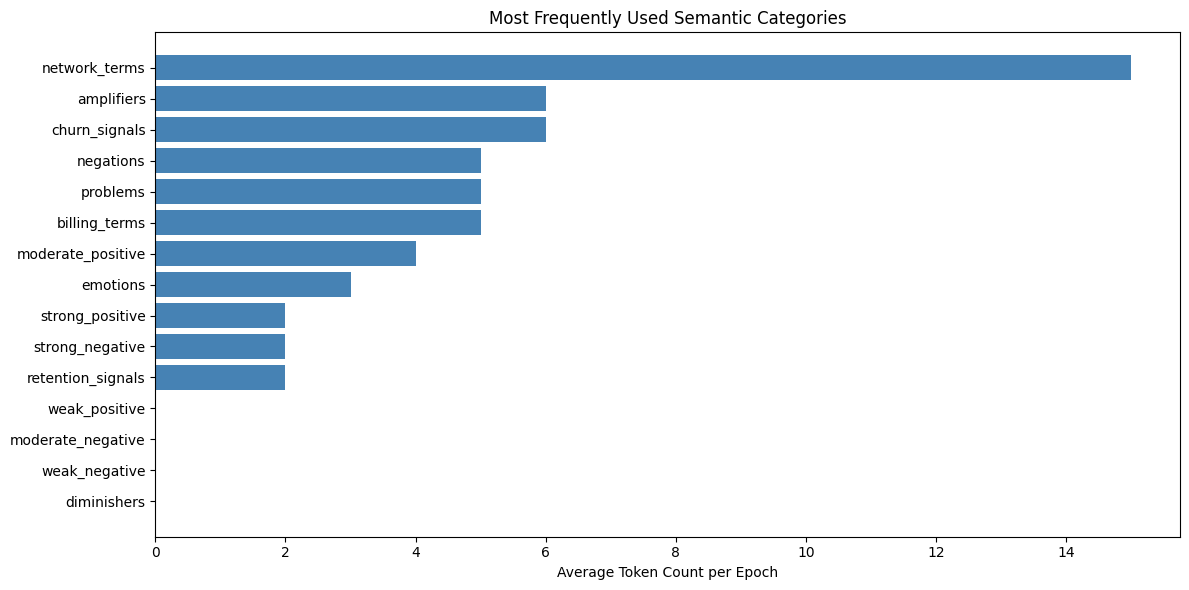


   Top 10 Most Important Categories:
       1. network_terms             : 15.0 avg tokens/epoch
       2. amplifiers                : 6.0 avg tokens/epoch
       3. churn_signals             : 6.0 avg tokens/epoch
       4. negations                 : 5.0 avg tokens/epoch
       5. problems                  : 5.0 avg tokens/epoch
       6. billing_terms             : 5.0 avg tokens/epoch
       7. moderate_positive         : 4.0 avg tokens/epoch
       8. emotions                  : 3.0 avg tokens/epoch
       9. strong_positive           : 2.0 avg tokens/epoch
      10. strong_negative           : 2.0 avg tokens/epoch

🧪 Step 8: Testing on New Examples
----------------------------------------------------------------------

   Predictions:

      Text: 'i want to cancel my service immediately'
      Prediction: 🔴 HIGH CHURN
      Confidence: Churn=1.000 | Retain=0.000
      Categories: {'churn_signals': 1}

      Text: 'very happy with the network coverage'
      Prediction: 🔴 HIGH C

In [17]:
# =============================================================================
# CELL 3: ENHANCED TRAINING WITH CATEGORY AWARENESS
# =============================================================================
class CategoryAwareSentimentTrainer:
    """
    Enhanced trainer that tracks semantic category usage during training.
    """
    def __init__(self, model, tokenizer, max_len=64):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # Track category importance over time
        self.category_importance = {cat: [] for cat in tokenizer.semantic_categories.keys()}

    def prepare_batch(self, texts: List[str], labels: List[int]):
        """Tokenize and pad texts."""
        encoded = []
        for text in texts:
            ids = self.tokenizer.encode(text)
            # Pad or truncate
            if len(ids) < self.max_len:
                ids = ids + [0] * (self.max_len - len(ids))
            else:
                ids = ids[:self.max_len]
            encoded.append(ids)

        input_ids = torch.tensor(encoded, device=self.device)
        labels_tensor = torch.tensor(labels, device=self.device)
        return input_ids, labels_tensor

    def train(self, texts: List[str], labels: List[int],
              epochs: int = 50, lr: float = 0.001, batch_size: int = 8,
              verbose: bool = True):
        """Train with category tracking."""

        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

        # Learning rate scheduler for better convergence
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )

        criterion = nn.CrossEntropyLoss()

        # Training history
        history = {
            'loss': [],
            'accuracy': [],
            'category_usage': [],
            'best_epoch': 0,
            'best_accuracy': 0.0
        }

        if verbose:
            print("🚀 Starting Category-Aware Training")
            print("=" * 70)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0
            epoch_category_counts = {cat: 0 for cat in self.tokenizer.semantic_categories.keys()}

            # Mini-batch training
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                batch_labels = labels[i:i+batch_size]

                # Track category usage in this batch
                for text in batch_texts:
                    cat_counts = self.tokenizer.analyze_text(text)
                    for cat, count in cat_counts.items():
                        if cat in epoch_category_counts:
                            epoch_category_counts[cat] += count

                # Prepare batch
                input_ids, label_tensor = self.prepare_batch(batch_texts, batch_labels)

                # Forward pass
                logits, interpretability = self.model(input_ids)

                # Use last token's prediction for classification
                logits_cls = logits[:, -1, :2]

                # Compute loss
                loss = criterion(logits_cls, label_tensor)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()

                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()

                # Track metrics
                total_loss += loss.item()
                predictions = torch.argmax(logits_cls, dim=-1)
                correct += (predictions == label_tensor).sum().item()
                total += len(batch_labels)

            # Epoch metrics
            avg_loss = total_loss / (len(texts) / batch_size)
            accuracy = correct / total

            # Update scheduler
            scheduler.step(avg_loss)

            # Track best model
            if accuracy > history['best_accuracy']:
                history['best_accuracy'] = accuracy
                history['best_epoch'] = epoch + 1

            history['loss'].append(avg_loss)
            history['accuracy'].append(accuracy)
            history['category_usage'].append(epoch_category_counts)

            # Store category importance
            for cat, count in epoch_category_counts.items():
                if cat in self.category_importance:
                    self.category_importance[cat].append(count)

            if verbose and (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f} | "
                      f"Accuracy: {accuracy:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if verbose:
            print("\n✅ Training Complete!")
            print(f"   Best Accuracy: {history['best_accuracy']:.4f} at Epoch {history['best_epoch']}")

        return history

    def evaluate(self, texts: List[str], labels: List[int], verbose: bool = True):
        """Evaluate model with detailed metrics."""
        self.model.eval()

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for i in range(0, len(texts), 8):
                batch_texts = texts[i:i+8]
                batch_labels = labels[i:i+8]

                input_ids, label_tensor = self.prepare_batch(batch_texts, batch_labels)
                logits, _ = self.model(input_ids)

                logits_cls = logits[:, -1, :2]
                predictions = torch.argmax(logits_cls, dim=-1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(label_tensor.cpu().numpy())

        # Calculate metrics
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        accuracy = (all_predictions == all_labels).mean()

        # Confusion matrix
        tp = ((all_predictions == 1) & (all_labels == 1)).sum()
        tn = ((all_predictions == 0) & (all_labels == 0)).sum()
        fp = ((all_predictions == 1) & (all_labels == 0)).sum()
        fn = ((all_predictions == 0) & (all_labels == 1)).sum()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        if verbose:
            print(f"\n📊 Evaluation Results:")
            print(f"{'='*70}")
            print(f"   Accuracy:  {accuracy:.4f}")
            print(f"   Precision: {precision:.4f}")
            print(f"   Recall:    {recall:.4f}")
            print(f"   F1-Score:  {f1:.4f}")
            print(f"\n   Confusion Matrix:")
            print(f"      True Neg:  {tn:3d}  |  False Pos: {fp:3d}")
            print(f"      False Neg: {fn:3d}  |  True Pos:  {tp:3d}")

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}
        }

    def analyze_predictions(self, texts: List[str], labels: List[int], top_n: int = 5):
        """Analyze model predictions with category breakdown."""
        self.model.eval()

        results = []

        with torch.no_grad():
            for text, label in zip(texts, labels):
                input_ids = torch.tensor([self.tokenizer.encode(text)], device=self.device)
                if input_ids.shape[1] < self.max_len:
                    input_ids = F.pad(input_ids, (0, self.max_len - input_ids.shape[1]))
                else:
                    input_ids = input_ids[:, :self.max_len]

                logits, interp = self.model(input_ids)
                logits_cls = logits[:, -1, :2]
                prediction = torch.argmax(logits_cls, dim=-1).item()
                confidence = torch.softmax(logits_cls, dim=-1)[0, prediction].item()

                # Analyze text categories
                categories = self.tokenizer.analyze_text(text)
                active_categories = {k: v for k, v in categories.items() if v > 0}

                results.append({
                    'text': text,
                    'true_label': label,
                    'prediction': prediction,
                    'confidence': confidence,
                    'correct': prediction == label,
                    'categories': active_categories
                })

        # Print top misclassifications
        misclassified = [r for r in results if not r['correct']]

        print(f"\n🔍 Prediction Analysis:")
        print(f"{'='*70}")
        print(f"   Total samples: {len(results)}")
        print(f"   Correct: {sum(r['correct'] for r in results)}")
        print(f"   Incorrect: {len(misclassified)}")

        if misclassified:
            print(f"\n   Top {min(top_n, len(misclassified))} Misclassifications:")
            for i, result in enumerate(misclassified[:top_n], 1):
                true_label = 'LOW CHURN' if result['true_label'] == 1 else 'HIGH CHURN'
                pred_label = 'LOW CHURN' if result['prediction'] == 1 else 'HIGH CHURN'
                print(f"\n   {i}. Text: '{result['text']}'")
                print(f"      True: {true_label} | Predicted: {pred_label} | Confidence: {result['confidence']:.3f}")
                print(f"      Categories: {result['categories']}")

        return results

    def plot_category_importance(self):
        """Visualize which semantic categories are most important."""
        import matplotlib.pyplot as plt

        # Calculate average usage per category
        avg_usage = {
            cat: np.mean(counts) if counts else 0
            for cat, counts in self.category_importance.items()
        }

        # Sort by importance
        sorted_cats = sorted(avg_usage.items(), key=lambda x: -x[1])[:15]

        categories = [cat for cat, _ in sorted_cats]
        values = [val for _, val in sorted_cats]

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.barh(categories, values, color='steelblue')
        ax.set_xlabel('Average Token Count per Epoch')
        ax.set_title('Most Frequently Used Semantic Categories')
        ax.invert_yaxis()

        plt.tight_layout()
        plt.show()

        return sorted_cats


# =============================================================================
# CELL 4: COMPLETE TRAINING PIPELINE
# =============================================================================
def run_comprehensive_training():
    """Complete training pipeline with all enhancements."""

    print("\n" + "="*70)
    print("GLASS BOX TRANSFORMER - COMPREHENSIVE CHURN PREDICTION")
    print("="*70)

    # Step 1: Create tokenizer
    print("\n📖 Step 1: Creating Comprehensive Tokenizer")
    print("-"*70)
    tokenizer = ComprehensiveChurnTokenizer()
    tokenizer.get_vocab_stats()

    # Step 2: Create dataset
    print("\n" + "="*70)
    print("📊 Step 2: Creating Churn Dataset")
    print("-"*70)
    texts, labels = create_comprehensive_churn_dataset()

    # Split into train/test
    split_idx = int(0.8 * len(texts))
    train_texts, test_texts = texts[:split_idx], texts[split_idx:]
    train_labels, test_labels = labels[:split_idx], labels[split_idx:]

    print(f"\n   Train set: {len(train_texts)} examples")
    print(f"   Test set:  {len(test_texts)} examples")

    # Step 3: Create model
    print("\n" + "="*70)
    print("🏗️  Step 3: Creating Glass Box Transformer")
    print("-"*70)

    model = GlassBoxTransformer(
        vocab_size=tokenizer.vocab_size,
        d_model=128,
        n_layers=4,
        n_heads=4,
        d_ff=512,
        max_seq_len=64
    )

    n_params = sum(p.numel() for p in model.parameters())
    print(f"   ✓ Model initialized")
    print(f"   ✓ Parameters: {n_params:,}")
    print(f"   ✓ Model size: ~{n_params * 4 / 1024 / 1024:.2f} MB")

    # Step 4: Train model
    print("\n" + "="*70)
    print("🚀 Step 4: Training Model")
    print("-"*70)

    trainer = CategoryAwareSentimentTrainer(model, tokenizer, max_len=64)
    history = trainer.train(
        train_texts,
        train_labels,
        epochs=50,
        lr=0.001,
        batch_size=8,
        verbose=True
    )

    # Step 5: Evaluate
    print("\n" + "="*70)
    print("📈 Step 5: Evaluating Model")
    print("-"*70)

    print("\n   Training Set Performance:")
    train_metrics = trainer.evaluate(train_texts, train_labels, verbose=True)

    print("\n   Test Set Performance:")
    test_metrics = trainer.evaluate(test_texts, test_labels, verbose=True)

    # Step 6: Analyze predictions
    print("\n" + "="*70)
    print("🔬 Step 6: Analyzing Predictions")
    print("-"*70)

    results = trainer.analyze_predictions(test_texts, test_labels, top_n=5)

    # Step 7: Visualize category importance
    print("\n" + "="*70)
    print("📊 Step 7: Category Importance Analysis")
    print("-"*70)

    top_categories = trainer.plot_category_importance()

    print(f"\n   Top 10 Most Important Categories:")
    for i, (cat, count) in enumerate(top_categories[:10], 1):
        print(f"      {i:2d}. {cat:<25} : {count:.1f} avg tokens/epoch")

    # Step 8: Test on new examples
    print("\n" + "="*70)
    print("🧪 Step 8: Testing on New Examples")
    print("-"*70)

    test_examples = [
        "i want to cancel my service immediately",
        "very happy with the network coverage",
        "terrible customer service experience",
        "staying with this provider for years",
        "switching to competitor next week",
        "excellent value for the price"
    ]

    model.eval()
    print("\n   Predictions:")
    with torch.no_grad():
        for text in test_examples:
            input_ids = torch.tensor([tokenizer.encode(text)], device=trainer.device)
            if input_ids.shape[1] < 64:
                input_ids = F.pad(input_ids, (0, 64 - input_ids.shape[1]))
            else:
                input_ids = input_ids[:, :64]

            logits, _ = model(input_ids)
            logits_cls = logits[:, -1, :2]
            probs = torch.softmax(logits_cls, dim=-1)[0]
            prediction = torch.argmax(probs).item()

            churn_prob = probs[0].item()
            retain_prob = probs[1].item()

            label = "🔴 HIGH CHURN" if prediction == 0 else "🟢 LOW CHURN"

            print(f"\n      Text: '{text}'")
            print(f"      Prediction: {label}")
            print(f"      Confidence: Churn={churn_prob:.3f} | Retain={retain_prob:.3f}")

            # Show category breakdown
            categories = tokenizer.analyze_text(text)
            active = {k: v for k, v in categories.items() if v > 0 and k != 'other'}
            if active:
                print(f"      Categories: {active}")

    print("\n" + "="*70)
    print("✅ TRAINING PIPELINE COMPLETE!")
    print("="*70)

    return model, tokenizer, trainer, history


# =============================================================================
# RUN EVERYTHING
# =============================================================================
if __name__ == "__main__":
    model, tokenizer, trainer, history = run_comprehensive_training()

In [7]:



# =============================================================================
# CELL 2: COMPREHENSIVE DOMAIN-SPECIFIC TOKENIZER
# =============================================================================
class ComprehensiveChurnTokenizer:
    """
    Enterprise-grade tokenizer with domain-specific vocabulary.
    Organized by linguistic and semantic categories for interpretability.
    """
    def __init__(self):
        # =============================================================================
        # SENTIMENT & EMOTION WORDS
        # =============================================================================

        # Strong positive sentiment
        strong_positive = [
            'amazing', 'awesome', 'excellent', 'outstanding', 'exceptional', 'phenomenal',
            'spectacular', 'superb', 'wonderful', 'fantastic', 'brilliant', 'magnificent',
            'marvelous', 'fabulous', 'terrific', 'stellar', 'supreme', 'unbeatable',
            'extraordinary', 'remarkable', 'impressive', 'stunning', 'dazzling'
        ]

        # Moderate positive sentiment
        moderate_positive = [
            'good', 'great', 'nice', 'fine', 'pleasant', 'positive', 'satisfactory',
            'acceptable', 'decent', 'solid', 'adequate', 'reasonable', 'fair',
            'delightful', 'enjoyable', 'lovely', 'sweet', 'pretty', 'favorable'
        ]

        # Weak positive sentiment
        weak_positive = [
            'okay', 'ok', 'alright', 'passable', 'tolerable', 'bearable', 'manageable'
        ]

        # Strong negative sentiment
        strong_negative = [
            'terrible', 'horrible', 'awful', 'atrocious', 'abysmal', 'dreadful',
            'appalling', 'horrendous', 'deplorable', 'disastrous', 'catastrophic',
            'nightmarish', 'unbearable', 'intolerable', 'unacceptable', 'abominable',
            'pathetic', 'miserable', 'wretched', 'despicable', 'detestable'
        ]

        # Moderate negative sentiment
        moderate_negative = [
            'bad', 'poor', 'subpar', 'inferior', 'inadequate', 'unsatisfactory',
            'disappointing', 'unfortunate', 'regrettable', 'unpleasant', 'negative',
            'problematic', 'troublesome', 'deficient', 'lacking', 'weak'
        ]

        # Weak negative sentiment
        weak_negative = [
            'mediocre', 'average', 'ordinary', 'unremarkable', 'forgettable', 'bland',
            'boring', 'dull', 'tedious', 'monotonous'
        ]

        # Emotional states
        emotions = [
            'happy', 'sad', 'angry', 'frustrated', 'annoyed', 'irritated', 'furious',
            'pleased', 'satisfied', 'content', 'delighted', 'thrilled', 'excited',
            'disappointed', 'upset', 'distressed', 'concerned', 'worried', 'anxious',
            'confused', 'surprised', 'shocked', 'amazed', 'grateful', 'thankful',
            'relieved', 'hopeful', 'optimistic', 'pessimistic', 'discouraged'
        ]

        # =============================================================================
        # INTENSITY MODIFIERS (ADVERBS)
        # =============================================================================

        # Amplifiers (intensify sentiment)
        amplifiers = [
            'very', 'extremely', 'incredibly', 'absolutely', 'completely', 'totally',
            'utterly', 'thoroughly', 'entirely', 'fully', 'highly', 'remarkably',
            'exceptionally', 'extraordinarily', 'particularly', 'especially', 'truly',
            'genuinely', 'really', 'seriously', 'desperately', 'severely', 'deeply',
            'profoundly', 'intensely', 'immensely', 'tremendously', 'enormously'
        ]

        # Diminishers (reduce sentiment)
        diminishers = [
            'slightly', 'somewhat', 'fairly', 'rather', 'quite', 'pretty',
            'relatively', 'moderately', 'reasonably', 'partially', 'partly',
            'barely', 'hardly', 'scarcely', 'marginally', 'minimally', 'nominally'
        ]

        # Frequency adverbs
        frequency = [
            'always', 'constantly', 'continually', 'frequently', 'often', 'regularly',
            'usually', 'normally', 'typically', 'generally', 'commonly', 'sometimes',
            'occasionally', 'rarely', 'seldom', 'never', 'hardly ever', 'repeatedly',
            'consistently', 'persistently', 'routinely'
        ]

        # Temporal adverbs
        temporal = [
            'now', 'currently', 'presently', 'today', 'recently', 'lately', 'yesterday',
            'previously', 'formerly', 'earlier', 'soon', 'immediately', 'instantly',
            'quickly', 'rapidly', 'swiftly', 'slowly', 'gradually', 'eventually',
            'finally', 'ultimately', 'already', 'still', 'yet', 'anymore'
        ]

        # =============================================================================
        # NEGATION & CONTRAST
        # =============================================================================

        # Negation words
        negations = [
            'not', 'no', 'never', 'neither', 'nobody', 'nothing', 'nowhere',
            'none', "n't", "won't", "can't", "don't", "doesn't", "didn't",
            "hasn't", "haven't", "hadn't", "isn't", "aren't", "wasn't", "weren't",
            "wouldn't", "shouldn't", "couldn't", "mightn't", "mustn't"
        ]

        # Contrast/adversative conjunctions
        contrast_words = [
            'but', 'however', 'although', 'though', 'yet', 'nevertheless',
            'nonetheless', 'whereas', 'while', 'despite', 'except', 'unfortunately',
            'sadly', 'regrettably', 'conversely', 'instead', 'rather', 'alternatively'
        ]

        # =============================================================================
        # CUSTOMER SERVICE & EXPERIENCE VOCABULARY
        # =============================================================================

        # Service quality descriptors
        service_quality = [
            'service', 'support', 'assistance', 'help', 'care', 'attention',
            'response', 'resolution', 'solution', 'handling', 'treatment',
            'professionalism', 'courtesy', 'politeness', 'friendliness', 'helpfulness',
            'efficiency', 'effectiveness', 'competence', 'expertise', 'knowledge',
            'responsiveness', 'availability', 'accessibility', 'reliability'
        ]

        # Customer experience terms
        experience_terms = [
            'experience', 'interaction', 'engagement', 'encounter', 'visit',
            'journey', 'process', 'procedure', 'transaction', 'communication',
            'correspondence', 'conversation', 'discussion', 'consultation', 'meeting'
        ]

        # Problem/issue terminology
        problems = [
            'problem', 'issue', 'trouble', 'difficulty', 'challenge', 'concern',
            'complaint', 'grievance', 'dispute', 'conflict', 'matter', 'situation',
            'complication', 'obstacle', 'hindrance', 'impediment', 'setback',
            'malfunction', 'failure', 'error', 'mistake', 'bug', 'glitch',
            'defect', 'flaw', 'fault', 'breakdown', 'outage', 'disruption'
        ]

        # =============================================================================
        # TELCO/TELECOM SPECIFIC VOCABULARY
        # =============================================================================

        # Network & connectivity
        network_terms = [
            'network', 'connection', 'connectivity', 'signal', 'coverage', 'reception',
            'bandwidth', 'speed', 'latency', 'lag', 'delay', 'buffering',
            'streaming', 'download', 'upload', 'throughput', 'quality',
            'stability', 'reliability', 'availability', 'uptime', 'downtime',
            'outage', 'interruption', 'disruption', 'interference'
        ]

        # Service types
        telco_services = [
            'phone', 'mobile', 'cellular', 'landline', 'telephone', 'call', 'calling',
            'internet', 'broadband', 'wifi', 'wireless', 'data', 'roaming',
            'voicemail', 'text', 'messaging', 'sms', 'mms', 'email',
            'tv', 'television', 'cable', 'satellite', 'streaming', 'video',
            'bundle', 'package', 'plan', 'subscription', 'contract', 'agreement'
        ]

        # Technical issues
        technical_issues = [
            'dropped', 'disconnected', 'lost', 'dead', 'frozen', 'stuck',
            'slow', 'sluggish', 'intermittent', 'unstable', 'unreliable',
            'spotty', 'patchy', 'inconsistent', 'degraded', 'throttled',
            'blocked', 'restricted', 'limited', 'capped', 'overcharged'
        ]

        # =============================================================================
        # BILLING & PRICING VOCABULARY
        # =============================================================================

        # Financial terms
        billing_terms = [
            'bill', 'billing', 'charge', 'charges', 'fee', 'fees', 'cost', 'costs',
            'price', 'pricing', 'rate', 'rates', 'payment', 'invoice', 'statement',
            'balance', 'amount', 'total', 'subtotal', 'tax', 'taxes',
            'discount', 'promotion', 'offer', 'deal', 'rebate', 'refund',
            'credit', 'debit', 'overcharge', 'undercharge', 'adjustment'
        ]

        # Value perception
        value_terms = [
            'value', 'worth', 'worthwhile', 'affordable', 'expensive', 'cheap',
            'costly', 'pricey', 'overpriced', 'underpriced', 'reasonable', 'fair',
            'unfair', 'excessive', 'exorbitant', 'competitive', 'economical',
            'budget', 'premium', 'luxury', 'standard', 'basic'
        ]

        # =============================================================================
        # CUSTOMER ACTIONS & INTENTIONS
        # =============================================================================

        # Churn signals (HIGH PRIORITY)
        churn_signals = [
            'cancel', 'canceling', 'cancelled', 'cancellation', 'terminate',
            'terminating', 'terminated', 'termination', 'discontinue', 'disconnect',
            'leave', 'leaving', 'left', 'quit', 'quitting', 'switch', 'switching',
            'switched', 'change', 'changing', 'changed', 'move', 'moving', 'moved',
            'transfer', 'transferring', 'end', 'ending', 'ended', 'stop', 'stopping',
            'stopped', 'drop', 'dropping', 'dropped'
        ]

        # Retention signals
        retention_signals = [
            'stay', 'staying', 'stayed', 'remain', 'remaining', 'remained',
            'continue', 'continuing', 'continued', 'renew', 'renewing', 'renewed',
            'extend', 'extending', 'extended', 'upgrade', 'upgrading', 'upgraded',
            'keep', 'keeping', 'kept', 'retain', 'retaining', 'retained'
        ]

        # Contact/engagement actions
        engagement_actions = [
            'contact', 'contacted', 'contacting', 'call', 'called', 'calling',
            'email', 'emailed', 'emailing', 'message', 'messaged', 'messaging',
            'chat', 'chatted', 'chatting', 'speak', 'spoke', 'spoken', 'speaking',
            'talk', 'talked', 'talking', 'reach', 'reached', 'reaching',
            'report', 'reported', 'reporting', 'complain', 'complained', 'complaining',
            'request', 'requested', 'requesting', 'ask', 'asked', 'asking'
        ]

        # =============================================================================
        # COMPARISON & COMPETITOR VOCABULARY
        # =============================================================================

        # Competitor mentions
        competitor_terms = [
            'competitor', 'competition', 'rival', 'alternative', 'option',
            'other', 'another', 'different', 'elsewhere', 'switch', 'compare',
            'comparison', 'versus', 'vs', 'better', 'worse', 'superior',
            'inferior', 'prefer', 'preference', 'choice'
        ]

        # =============================================================================
        # TEMPORAL EXPRESSIONS
        # =============================================================================

        # Duration
        duration_terms = [
            'second', 'seconds', 'minute', 'minutes', 'hour', 'hours',
            'day', 'days', 'week', 'weeks', 'month', 'months', 'year', 'years',
            'long', 'short', 'brief', 'extended', 'prolonged', 'temporary',
            'permanent', 'ongoing', 'continuous'
        ]

        # Time references
        time_references = [
            'ago', 'since', 'until', 'till', 'from', 'to', 'between',
            'during', 'within', 'after', 'before', 'past', 'future',
            'present', 'current', 'previous', 'next', 'last', 'first'
        ]

        # =============================================================================
        # STANDARD LINGUISTIC CATEGORIES
        # =============================================================================

        # Common verbs
        common_verbs = [
            'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being',
            'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
            'make', 'makes', 'made', 'making', 'get', 'gets', 'got', 'getting',
            'go', 'goes', 'went', 'going', 'gone', 'come', 'comes', 'came', 'coming',
            'take', 'takes', 'took', 'taking', 'taken', 'see', 'sees', 'saw', 'seeing', 'seen',
            'know', 'knows', 'knew', 'knowing', 'known', 'think', 'thinks', 'thought', 'thinking',
            'give', 'gives', 'gave', 'giving', 'given', 'find', 'finds', 'found', 'finding',
            'tell', 'tells', 'told', 'telling', 'become', 'becomes', 'became', 'becoming',
            'show', 'shows', 'showed', 'showing', 'shown', 'let', 'lets', 'letting',
            'begin', 'begins', 'began', 'beginning', 'begun', 'seem', 'seems', 'seemed', 'seeming',
            'help', 'helps', 'helped', 'helping', 'try', 'tries', 'tried', 'trying',
            'use', 'uses', 'used', 'using', 'need', 'needs', 'needed', 'needing',
            'want', 'wants', 'wanted', 'wanting', 'work', 'works', 'worked', 'working',
            'feel', 'feels', 'felt', 'feeling', 'become', 'becomes', 'became', 'becoming',
            'provide', 'provides', 'provided', 'providing', 'lose', 'loses', 'lost', 'losing',
            'pay', 'pays', 'paid', 'paying', 'meet', 'meets', 'met', 'meeting',
            'include', 'includes', 'included', 'including', 'continue', 'continues', 'continued',
            'set', 'sets', 'setting', 'learn', 'learns', 'learned', 'learning',
            'add', 'adds', 'added', 'adding', 'understand', 'understands', 'understood', 'understanding'
        ]

        # Common nouns
        common_nouns = [
            'time', 'person', 'people', 'year', 'way', 'day', 'thing', 'man', 'woman',
            'world', 'life', 'hand', 'part', 'child', 'children', 'eye', 'place', 'work',
            'week', 'case', 'point', 'government', 'company', 'number', 'group', 'fact',
            'water', 'room', 'money', 'story', 'book', 'movie', 'car', 'house', 'food',
            'music', 'idea', 'business', 'system', 'program', 'question', 'information',
            'family', 'friend', 'school', 'student', 'game', 'team', 'job', 'city',
            'country', 'state', 'community', 'area', 'result', 'change', 'product',
            'market', 'customer', 'client', 'member', 'account', 'user', 'representative',
            'agent', 'manager', 'supervisor', 'department', 'office', 'center', 'store'
        ]

        # Common adjectives
        common_adjectives = [
            'new', 'old', 'high', 'low', 'big', 'small', 'large', 'little', 'long', 'short',
            'early', 'late', 'young', 'important', 'different', 'same', 'right', 'wrong',
            'able', 'unable', 'certain', 'possible', 'impossible', 'available', 'unavailable',
            'full', 'empty', 'whole', 'complete', 'incomplete', 'open', 'closed',
            'public', 'private', 'personal', 'professional', 'social', 'economic',
            'political', 'national', 'international', 'local', 'global', 'general',
            'specific', 'particular', 'special', 'normal', 'regular', 'standard',
            'simple', 'complex', 'easy', 'difficult', 'hard', 'clear', 'unclear',
            'strong', 'weak', 'free', 'busy', 'ready', 'sure', 'unsure'
        ]

        # Pronouns
        pronouns = [
            'i', 'me', 'my', 'mine', 'myself',
            'you', 'your', 'yours', 'yourself', 'yourselves',
            'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself',
            'it', 'its', 'itself',
            'we', 'us', 'our', 'ours', 'ourselves',
            'they', 'them', 'their', 'theirs', 'themselves',
            'this', 'that', 'these', 'those',
            'who', 'whom', 'whose', 'which', 'what',
            'anybody', 'anyone', 'anything', 'everybody', 'everyone', 'everything',
            'somebody', 'someone', 'something', 'nobody', 'none', 'nothing'
        ]

        # Prepositions
        prepositions = [
            'of', 'in', 'to', 'for', 'with', 'on', 'at', 'from', 'by', 'about',
            'as', 'into', 'like', 'through', 'after', 'over', 'between', 'out',
            'against', 'during', 'without', 'before', 'under', 'around', 'among',
            'beneath', 'beside', 'below', 'above', 'across', 'behind', 'beyond',
            'plus', 'except', 'near', 'off', 'per', 'regarding', 'since', 'than',
            'toward', 'towards', 'upon', 'within', 'via', 'throughout'
        ]

        # Conjunctions
        conjunctions = [
            'and', 'or', 'but', 'if', 'because', 'as', 'while', 'when', 'where',
            'although', 'though', 'unless', 'until', 'since', 'so', 'whether',
            'nor', 'yet', 'either', 'neither', 'both'
        ]

        # Determiners
        determiners = [
            'the', 'a', 'an', 'this', 'that', 'these', 'those', 'my', 'your',
            'his', 'her', 'its', 'our', 'their', 'some', 'any', 'all', 'each',
            'every', 'no', 'many', 'much', 'few', 'little', 'several', 'most',
            'more', 'less', 'fewer', 'other', 'another', 'such', 'own'
        ]

        # Modal verbs
        modals = [
            'can', 'could', 'may', 'might', 'must', 'shall', 'should',
            'will', 'would', 'ought', 'need', 'dare'
        ]

        # Numbers and quantifiers
        numbers = [str(i) for i in range(0, 101)] + [
            'hundred', 'thousand', 'million', 'billion', 'trillion',
            'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',
            'eight', 'nine', 'ten', 'first', 'second', 'third', 'fourth',
            'fifth', 'once', 'twice', 'double', 'triple', 'half', 'quarter',
            'dozen', 'couple', 'multiple', 'single', 'numerous', 'countless'
        ]

        # Question words
        question_words = [
            'who', 'what', 'when', 'where', 'why', 'how', 'which', 'whose',
            'whom', 'whatever', 'whenever', 'wherever', 'however', 'whichever'
        ]

        # =============================================================================
        # PUNCTUATION & SPECIAL TOKENS
        # =============================================================================

        punctuation = [
            '.', ',', '!', '?', ';', ':', '-', '--', '—', '(', ')', '[', ']',
            '{', '}', '"', "'", '`', '/', '\\', '|', '@', '#', '$', '%', '&',
            '*', '+', '=', '<', '>', '~', '^'
        ]

        # =============================================================================
        # COMBINE ALL VOCABULARIES
        # =============================================================================

        all_word_lists = [
            # Sentiment
            strong_positive, moderate_positive, weak_positive,
            strong_negative, moderate_negative, weak_negative, emotions,
            # Modifiers
            amplifiers, diminishers, frequency, temporal,
            # Negation & contrast
            negations, contrast_words,
            # Customer service
            service_quality, experience_terms, problems,
            # Telco specific
            network_terms, telco_services, technical_issues,
            # Billing
            billing_terms, value_terms,
            # Actions
            churn_signals, retention_signals, engagement_actions,
            # Comparison
            competitor_terms,
            # Temporal
            duration_terms, time_references,
            # Standard linguistic
            common_verbs, common_nouns, common_adjectives,
            pronouns, prepositions, conjunctions, determiners,
            modals, numbers, question_words, punctuation
        ]

        # Flatten and remove duplicates
        self.vocab_words = []
        for word_list in all_word_lists:
            self.vocab_words.extend(word_list)

        self.vocab_words = sorted(list(set(self.vocab_words)))

        # Build mappings with special tokens
        self.word_to_idx = {
            '<PAD>': 0,
            '<UNK>': 1,
            '<SOS>': 2,  # Start of sequence
            '<EOS>': 3,  # End of sequence
        }

        for i, word in enumerate(self.vocab_words, start=4):
            self.word_to_idx[word] = i

        self.idx_to_word = {v: k for k, v in self.word_to_idx.items()}
        self.vocab_size = len(self.word_to_idx)

        # Create semantic category mappings for interpretability
        self.semantic_categories = {
            'strong_positive': set(strong_positive),
            'moderate_positive': set(moderate_positive),
            'weak_positive': set(weak_positive),
            'strong_negative': set(strong_negative),
            'moderate_negative': set(moderate_negative),
            'weak_negative': set(weak_negative),
            'emotions': set(emotions),
            'amplifiers': set(amplifiers),
            'diminishers': set(diminishers),
            'negations': set(negations),
            'churn_signals': set(churn_signals),
            'retention_signals': set(retention_signals),
            'problems': set(problems),
            'network_terms': set(network_terms),
            'billing_terms': set(billing_terms),
        }

    def encode(self, text: str) -> List[int]:
        """Convert text to token IDs."""
        text = text.lower()
        # Simple whitespace and punctuation tokenization
        import re
        # Split on whitespace and keep punctuation
        tokens = re.findall(r'\w+|[^\w\s]', text)
        return [self.word_to_idx.get(token, self.word_to_idx['<UNK>']) for token in tokens]

    def decode(self, ids: List[int]) -> str:
        """Convert token IDs back to text."""
        words = [self.idx_to_word.get(idx, '<UNK>') for idx in ids]
        # Simple detokenization
        text = ' '.join(words)
        # Fix punctuation spacing
        import re
        text = re.sub(r'\s+([.,!?;:])', r'\1', text)
        text = re.sub(r'\(\s+', '(', text)
        text = re.sub(r'\s+\)', ')', text)
        return text

    def get_word_category(self, word: str) -> List[str]:
        """Return all semantic categories a word belongs to."""
        word = word.lower()
        categories = []
        for cat_name, cat_words in self.semantic_categories.items():
            if word in cat_words:
                categories.append(cat_name)
        return categories if categories else ['other']

    def analyze_text(self, text: str) -> Dict:
        """Analyze text and return category breakdown."""
        tokens = text.lower().split()
        category_counts = {cat: 0 for cat in self.semantic_categories.keys()}
        category_counts['other'] = 0

        for token in tokens:
            categories = self.get_word_category(token)
            for cat in categories:
                category_counts[cat] += 1

        return category_counts

    def get_vocab_stats(self):
        """Print comprehensive vocabulary statistics."""
        print(f"📚 Comprehensive Churn Tokenizer Statistics:")
        print(f"{'='*70}")
        print(f"   Total vocabulary size: {self.vocab_size:,} tokens")
        print(f"   Content words: {len(self.vocab_words):,}")
        print(f"\n   📊 Category Breakdown:")

        category_sizes = {
            name: len(words)
            for name, words in self.semantic_categories.items()
        }

        for cat_name, size in sorted(category_sizes.items(), key=lambda x: -x[1])[:15]:
            print(f"      {cat_name:<25} : {size:>4} words")

        print(f"\n   🔤 Sample tokens (first 30):")
        for i, word in enumerate(self.vocab_words[:30]):
            categories = self.get_word_category(word)
            cat_str = ', '.join(categories[:2])  # Show first 2 categories
            print(f"      {i+4:>4}: '{word:<20}' [{cat_str}]")
        print(f"      ...")


# =============================================================================
# CELL 2B: COMPREHENSIVE CHURN DATASET
# =============================================================================
def create_comprehensive_churn_dataset():
    """
    Create realistic customer churn dataset with diverse scenarios.
    """

    # HIGH CHURN RISK - Negative texts (label = 0)
    high_churn_texts = [
        # Direct cancellation intent
        "i want to cancel my service",
        "please cancel my account immediately",
        "i am cancelling my subscription today",
        "need to terminate my contract",
        "i would like to discontinue service",

        # Switching to competitor
        "switching to another provider next month",
        "found better deal with competitor",
        "moving to different company",
        "competitor offers better service",
        "leaving for cheaper alternative",

        # Service quality complaints
        "terrible network coverage in my area",
        "internet speed is extremely slow",
        "dropped calls constantly",
        "connection keeps disconnecting",
        "service is completely unreliable",
        "network outage every single day",

        # Billing complaints
        "bills are way too expensive",
        "overcharged again this month",
        "hidden fees everywhere",
        "billing errors every month",
        "price increased without notice",

        # Customer service complaints
        "customer service is absolutely horrible",
        "waited hours for support",
        "representatives are very rude",
        "nobody helps with my problems",
        "worst customer service ever",

        # Frustrated with ongoing issues
        "nothing works properly anymore",
        "tired of dealing with constant problems",
        "same issue for months now",
        "completely fed up with service",
        "this is getting ridiculous",

        # Complex negative scenarios
        "internet drops every hour and support does not help",
        "paying too much for terrible service quality",
        "been customer for years but treated poorly",
        "promised better service but got worse",
        "completely disappointed with everything",
    ]

    # LOW CHURN RISK - Positive texts (label = 1)
    low_churn_texts = [
        # Satisfaction expressions
        "very happy with my service",
        "excellent network coverage",
        "great value for money",
        "super reliable connection",
        "fast internet speed always",

        # Positive service experiences
        "customer support was very helpful",
        "representative solved my problem quickly",
        "easy to contact support team",
        "friendly and professional service",
        "issue resolved immediately",

        # Loyalty signals
        "been customer for years",
        "staying with this provider",
        "recently upgraded my plan",
        "renewed my contract",
        "recommended to family and friends",

        # Positive comparisons
        "much better than previous provider",
        "best service in the area",
        "no complaints at all",
        "everything works perfectly",
        "consistently good experience",

        # Value appreciation
        "fair pricing for quality",
        "good deals available",
        "affordable monthly bill",
        "worth every penny",
        "competitive rates",

        # Quality praise
        "crystal clear call quality",
        "blazing fast download speeds",
        "stable connection always",
        "never experienced outage",
        "service exceeded expectations",

        # Complex positive scenarios
        "had minor issue but support fixed quickly",
        "great service and reasonable price together",
        "reliable network and excellent customer care",
        "upgraded plan and very satisfied",
        "longtime customer and still happy",
]



# Create balanced dataset
texts = high_churn_texts + low_churn_texts
labels = [0] * len(high_churn_texts) + [1] * len(low_churn_texts)

# Shuffle
indices = torch.randperm(len(texts))
texts = [texts[i] for i in indices]
labels = [labels[i] for i in indices]

print(f"📊 Comprehensive Churn Dataset Created:")
print(f"{'='*70}")
print(f"   Total examples: {len(texts)}")
print(f"   High churn risk (0): {sum(1 for l in labels if l == 0)}")
print(f"   Low churn risk (1): {sum(1 for l in labels if l == 1)}")
print(f"\n   Sample examples:")
for i in range(6):
    risk = 'HIGH CHURN' if labels[i] == 0 else 'LOW CHURN'
    print(f"      [{risk}] {texts[i]}")

return texts, labels





# =============================================================================
# CELL 4: Training Loop
# =============================================================================
class SentimentTrainer:
    def __init__(self, model, tokenizer, max_len=64):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        # IMPORTANT: Store token IDs for semantic role detection
        self.token_ids_cache = {}

    def prepare_batch(self, texts: List[str], labels: List[int]):
        """Tokenize and pad texts."""
        encoded = []
        for text in texts:
            ids = self.tokenizer.encode(text)
            # Pad or truncate
            if len(ids) < self.max_len:
                ids = ids + [0] * (self.max_len - len(ids))
            else:
                ids = ids[:self.max_len]
            encoded.append(ids)

        input_ids = torch.tensor(encoded, device=self.device)
        labels_tensor = torch.tensor(labels, device=self.device)
        return input_ids, labels_tensor

    def train(self, texts: List[str], labels: List[int],
              epochs: int = 50, lr: float = 0.001, batch_size: int = 8):
        """Train the model on sentiment classification."""

        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training history
        history = {'loss': [], 'accuracy': [], 'context_usage': []}

        print("🚀 Starting Training with Context-Awareness")
        print("=" * 50)

        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            correct = 0
            total = 0
            epoch_context_usage = []

            # Mini-batch training
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i+batch_size]
                batch_labels = labels[i:i+batch_size]

                # Prepare batch
                input_ids, label_tensor = self.prepare_batch(batch_texts, batch_labels)

                # Forward pass
                logits, interpretability = self.model(input_ids)

                # Track context usage for monitoring
                if 'rules' in interpretability:
                    epoch_context_usage.append(
                        interpretability['rules']['avg_rules_per_token']
                    )

                # Use last token's prediction for classification
                logits_cls = logits[:, -1, :2]  # Only use first 2 logits for binary classification

                # Compute loss
                loss = criterion(logits_cls, label_tensor)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Track metrics
                total_loss += loss.item()
                predictions = torch.argmax(logits_cls, dim=-1)
                correct += (predictions == label_tensor).sum().item()
                total += len(batch_labels)

            # Epoch metrics
            avg_loss = total_loss / (len(texts) / batch_size)
            accuracy = correct / total
            avg_context = sum(epoch_context_usage) / len(epoch_context_usage) if epoch_context_usage else 0

            history['loss'].append(avg_loss)
            history['accuracy'].append(accuracy)
            history['context_usage'].append(avg_context)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f} | Context: {avg_context:.3f}")

            # Prune rules every 10 epochs to maintain efficiency
            if hasattr(self.model, 'rule_layer') and (epoch + 1) % 10 == 0:
                self.model.rule_layer.prune_rules(threshold=0.01)

        print("\n✅ Training Complete!")
        return history


# =============================================================================
# CELL 5: Run Everything
# =============================================================================
if __name__ == "__main__":
    # Test architecture
    print("\n" + "="*70)
    print("STEP 1: Initialize Model")
    print("="*70)
    model = test_architecture()

    # Create tokenizer
    print("\n" + "="*70)
    print("STEP 2: Create Expanded Tokenizer")
    print("="*70)
    tokenizer = ExpandedTokenizer()
    tokenizer.get_vocab_stats()

    # Reinitialize model with correct vocab size
    model = GlassBoxTransformer(
        vocab_size=tokenizer.vocab_size,
        d_model=128,  # Larger model for bigger vocab
        n_layers=4,
        n_heads=8,
        d_ff=512,
        max_seq_len=64  # Longer sequences
    )

# =============================================================================
# MISSING CELL: Curriculum Dataset Creation
# =============================================================================
def create_curriculum_dataset():
    """Create better curriculum with more examples and variety."""
    print("Creating ENHANCED Curriculum Learning Dataset...")

    curriculum_stages = {
        'stage_1': {
            'name': 'Word-Level Foundation',
            'texts': [
                "good", "bad", "love", "hate", "nice", "poor",
                "great", "awful", "happy", "sad", "best", "worst",
                "amazing", "terrible", "wonderful", "horrible", "excellent", "disgusting"
            ],
            'labels': [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
            'description': 'Single word classification with more words'
        },
        'stage_2': {
            'name': 'Pattern Generalization',
            'texts': [
                "i love this", "i hate this", "this is good", "this is bad",
                "very nice", "very poor", "so happy", "so sad",
                "best thing", "worst thing", "great job", "awful job",
                "amazing work", "terrible work", "wonderful day", "horrible day"
            ],
            'labels': [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0],
            'description': 'Short phrases with pattern variety'
        },
        # ... keep other stages but maybe reduce epochs for later stages
    }

    return curriculum_stages

# =============================================================================
# FIXED & ENHANCED Curriculum Trainer Class
# =============================================================================
class CurriculumTrainer:
    def __init__(self, model, tokenizer, max_len=64):
        self.model = model
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

    def prepare_batch(self, texts: List[str], labels: List[int]):
        """Tokenize and pad texts."""
        encoded = []
        for text in texts:
            ids = self.tokenizer.encode(text)
            if len(ids) < self.max_len:
                ids = ids + [0] * (self.max_len - len(ids))
            else:
                ids = ids[:self.max_len]
            encoded.append(ids)

        input_ids = torch.tensor(encoded, device=self.device)
        labels_tensor = torch.tensor(labels, device=self.device)
        return input_ids, labels_tensor

    def train_stage(self, texts: List[str], labels: List[int],
               epochs: int = 30, lr: float = 0.001, batch_size: int = 8):
      """Train on a single curriculum stage with enhancements."""
      # BETTER OPTIMIZER WITH REGULARIZATION
      optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)

      # 🔥 CRITICAL FIX: ADD CLASS BALANCING
      pos_count = sum(labels)
      neg_count = len(labels) - pos_count
      total_count = len(labels)

      if pos_count > 0 and neg_count > 0:
          # Calculate class weights to balance the loss
          weight_for_positive = total_count / (2.0 * pos_count)
          weight_for_negative = total_count / (2.0 * neg_count)
          class_weights = torch.tensor([weight_for_negative, weight_for_positive], device=self.device)
          criterion = nn.CrossEntropyLoss(weight=class_weights)
          print(f"    Class weights - Positive: {weight_for_positive:.2f}, Negative: {weight_for_negative:.2f}")
      else:
          criterion = nn.CrossEntropyLoss()

      # LEARNING RATE SCHEDULER
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

      stage_history = {'loss': [], 'accuracy': []}

      for epoch in range(epochs):
          self.model.train()
          total_loss = 0
          correct = 0
          total = 0

          # 🔥 CRITICAL FIX: SHUFFLE DATA EACH EPOCH
          indices = torch.randperm(len(texts))
          shuffled_texts = [texts[i] for i in indices]
          shuffled_labels = [labels[i] for i in indices]

          # Mini-batch training
          for i in range(0, len(shuffled_texts), batch_size):
              batch_texts = shuffled_texts[i:i+batch_size]
              batch_labels = shuffled_labels[i:i+batch_size]

              input_ids, label_tensor = self.prepare_batch(batch_texts, batch_labels)

              # Forward pass
              logits, interpretability = self.model(input_ids)
              logits_cls = logits[:, -1, :2]

              # Compute loss (now with class balancing)
              loss = criterion(logits_cls, label_tensor)

              # 🔥 ADD GRADIENT CLIPPING
              optimizer.zero_grad()
              loss.backward()
              torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
              optimizer.step()

              # Track metrics
              total_loss += loss.item()
              predictions = torch.argmax(logits_cls, dim=-1)
              correct += (predictions == label_tensor).sum().item()
              total += len(batch_labels)

          # Update learning rate
          scheduler.step()

          # Epoch metrics
          avg_loss = total_loss / max(1, (len(texts) / batch_size))
          accuracy = correct / total if total > 0 else 0

          stage_history['loss'].append(avg_loss)
          stage_history['accuracy'].append(accuracy)

          # Print more frequent progress for debugging
          if (epoch + 1) % 5 == 0:
              print(f"    Epoch {epoch+1:3d}: Loss={avg_loss:.4f}, Acc={accuracy:.4f}")

          # Early stopping check
          if epoch > 10 and accuracy > 0.95:
              print(f"    Early stopping at epoch {epoch+1} (accuracy: {accuracy:.4f})")
              break

      return stage_history

    def train_curriculum(self, curriculum_stages: Dict, epochs_per_stage: int = 30,
                        lr: float = 0.001, batch_size: int = 8):
        """Train through all curriculum stages with progressive difficulty."""
        all_history = {}
        stage_insights = {}

        print("🎓 Starting ENHANCED Curriculum Learning...")
        print("=" * 60)

        # 🔥 ADD HOLDOUT VALIDATION SET
        holdout_texts = ["amazing", "terrible", "i love it", "i hate it", "very good", "very bad"]
        holdout_labels = [1, 0, 1, 0, 1, 0]

        for stage_key, stage_data in curriculum_stages.items():
            print(f"\n📚 Stage: {stage_data['name']}")
            print(f"   Examples: {len(stage_data['texts'])}")
            print(f"   Description: {stage_data['description']}")

            # Train on this stage
            stage_history = self.train_stage(
                stage_data['texts'],
                stage_data['labels'],
                epochs=epochs_per_stage,
                lr=lr,
                batch_size=batch_size
            )

            # 🔥 ADD HOLDOUT VALIDATION
            holdout_acc = self.evaluate_holdout(holdout_texts, holdout_labels)

            # Evaluate stage performance
            final_accuracy = stage_history['accuracy'][-1] if stage_history['accuracy'] else 0
            final_loss = stage_history['loss'][-1] if stage_history['loss'] else 0

            print(f"   Results: Loss={final_loss:.4f}, Train Acc={final_accuracy:.4f}, Holdout Acc={holdout_acc:.4f}")

            # Store results
            all_history[stage_key] = stage_history
            stage_insights[stage_key] = {
                'final_accuracy': final_accuracy,
                'final_loss': final_loss,
                'holdout_accuracy': holdout_acc,
                'examples_trained': len(stage_data['texts'])
            }

            # 🔥 ADAPTIVE LEARNING RATE - reduce if overfitting
            if holdout_acc < final_accuracy - 0.2:  # Overfitting detected
                lr *= 0.8
                print(f"   Reducing learning rate to {lr:.6f} (overfitting detected)")

        print("\n✅ Enhanced Curriculum Learning Complete!")
        return all_history, stage_insights

    def evaluate_holdout(self, texts: List[str], labels: List[int]):
        """Evaluate on holdout set to detect overfitting."""
        self.model.eval()
        correct = 0

        with torch.no_grad():
            for text, label in zip(texts, labels):
                input_ids, label_tensor = self.prepare_batch([text], [label])
                logits, _ = self.model(input_ids)
                logits_cls = logits[:, -1, :2]
                prediction = torch.argmax(logits_cls, dim=-1).item()
                if prediction == label:
                    correct += 1

        return correct / len(texts)

    def train_curriculum(self, curriculum_stages: Dict, epochs_per_stage: int = 15,
                        lr: float = 0.001, batch_size: int = 8):
        """Train through all curriculum stages."""
        all_history = {}
        stage_insights = {}

        print("🎓 Starting Curriculum Learning...")
        print("=" * 60)

        for stage_key, stage_data in curriculum_stages.items():
            print(f"\n📚 Stage: {stage_data['name']}")
            print(f"   Examples: {len(stage_data['texts'])}")
            print(f"   Description: {stage_data['description']}")

            # Train on this stage
            stage_history = self.train_stage(
                stage_data['texts'],
                stage_data['labels'],
                epochs=epochs_per_stage,
                lr=lr,
                batch_size=batch_size
            )

            # Evaluate stage performance
            final_accuracy = stage_history['accuracy'][-1] if stage_history['accuracy'] else 0
            final_loss = stage_history['loss'][-1] if stage_history['loss'] else 0

            print(f"   Results: Loss={final_loss:.4f}, Accuracy={final_accuracy:.4f}")

            # Store results
            all_history[stage_key] = stage_history
            stage_insights[stage_key] = {
                'final_accuracy': final_accuracy,
                'final_loss': final_loss,
                'examples_trained': len(stage_data['texts'])
            }

        print("\n✅ Curriculum Learning Complete!")
        return all_history, stage_insights

# =============================================================================
# CELL 5: Jupyter Training Execution
# =============================================================================

# =============================================================================
# MISSING FUNCTION: test_new_examples
# =============================================================================
def test_new_examples(model, tokenizer, trainer):
    """Test the model on completely new examples it hasn't seen."""
    print("\n" + "="*70)
    print("TESTING ON NEW EXAMPLES (Generalization)")
    print("="*70)

    new_tests = [
        # Should be positive
        ("amazing idea", 1),
        ("super happy", 1),
        ("very good", 1),
        ("i enjoy this", 1),
        ("brilliant work", 1),

        # Should be negative
        ("terrible mistake", 0),
        ("very poor", 0),
        ("i hate it", 0),
        ("awful idea", 0),
        ("really bad", 0),

        # Edge cases
        ("ok", 1),  # Neutral-ish
        ("not bad", 1),  # Double negative
        ("not good", 0),  # Negation
    ]

    model.eval()
    correct = 0

    print(f"\n{'Text':<25} {'Expected':<12} {'Predicted':<12} {'Confidence':<12} {'Result'}")
    print("-" * 75)

    results = []
    for text, expected_label in new_tests:
        with torch.no_grad():
            input_ids, _ = trainer.prepare_batch([text], [expected_label])
            logits, interp = model(input_ids)

            logits_cls = logits[:, -1, :2]
            probs = F.softmax(logits_cls, dim=-1)
            pred_label = torch.argmax(probs, dim=-1).item()
            confidence = probs[0, pred_label].item()

            expected_str = "Positive" if expected_label == 1 else "Negative"
            predicted_str = "Positive" if pred_label == 1 else "Negative"
            is_correct = pred_label == expected_label
            correct += is_correct

            result_icon = "✓" if is_correct else "✗"

            print(f"{text:<25} {expected_str:<12} {predicted_str:<12} {confidence:>6.2%}      {result_icon}")

            results.append({
                'text': text,
                'expected': expected_label,
                'predicted': pred_label,
                'confidence': confidence,
                'correct': is_correct,
                'interpretability': interp
            })

    accuracy = correct / len(new_tests)
    print("-" * 75)
    print(f"Generalization Accuracy: {accuracy:.2%} ({correct}/{len(new_tests)})")

    return results

# =============================================================================
# MISSING FUNCTION: debug_initial_model_state
# =============================================================================
def debug_initial_model_state(model, tokenizer, trainer):
    """See what the model predicts before any training."""
    print("\n" + "="*70)
    print("INITIAL MODEL STATE (BEFORE TRAINING)")
    print("="*70)

    test_words = ["good", "bad", "test", "hello"]

    print("\n🔍 Random Initial Predictions:")
    for word in test_words:
        input_ids, _ = trainer.prepare_batch([word], [0])
        with torch.no_grad():
            logits, _ = model(input_ids)
            probs = F.softmax(logits[:, -1, :2], dim=-1)
            pos_prob = probs[0, 1].item()
            neg_prob = probs[0, 0].item()

            print(f"  '{word}': Positive={pos_prob:.3f}, Negative={neg_prob:.3f}")

# =============================================================================
# SIMPLIFIED CELL 5 - Just the essentials
# =============================================================================

# Cell 5a: Create Curriculum Dataset
print("\n" + "="*70)
print("STEP 3: Create Curriculum Learning Dataset")
print("="*70)
curriculum_stages = create_curriculum_dataset()

# Cell 5b: Initialize Trainer
print("\n" + "="*70)
print("STEP 4: Initialize Trainer")
print("="*70)
trainer = CurriculumTrainer(model, tokenizer)
print("✅ Trainer ready!")

# Cell 5c: Check Initial Model State
print("\n" + "="*70)
print("STEP 5: Check Initial Model Knowledge")
print("="*70)
debug_initial_model_state(model, tokenizer, trainer)

# =============================================================================
# CELL 5d: FIND OPTIMAL SETTINGS
# =============================================================================

print("\n" + "="*70)
print("STEP 4: FIND OPTIMAL SETTINGS")
print("="*70)

def find_optimal_settings(model, tokenizer, curriculum_stages):
    """Automatically find the best learning rate and epochs."""
    print("🔬 Testing different learning rates and epochs...")

    best_accuracy = 0
    best_settings = {}

    # Test different learning rates
    learning_rates = [0.0001, 0.0005, 0.001]
    epochs_options = [10, 15]

    for lr in learning_rates:
        for epochs in epochs_options:
            print(f"\n🧪 Testing: lr={lr}, epochs={epochs}")

            # Reset model to fresh state
            model_copy = GlassBoxTransformer(
                vocab_size=tokenizer.vocab_size,
                d_model=128,
                n_layers=4,
                n_heads=8,
                d_ff=512,
                max_seq_len=64
            )

            trainer_copy = CurriculumTrainer(model_copy, tokenizer)

            # Quick train on first stage only
            stage_data = curriculum_stages['stage_1']
            history = trainer_copy.train_stage(
                stage_data['texts'],
                stage_data['labels'],
                epochs=epochs,
                lr=lr,
                batch_size=8
            )

            final_acc = history['accuracy'][-1] if history['accuracy'] else 0

            print(f"   Result: Final Accuracy = {final_acc:.4f}")

            if final_acc > best_accuracy:
                best_accuracy = final_acc
                best_settings = {'lr': lr, 'epochs': epochs}
                print(f"   🏆 NEW BEST!")

    print(f"\n🎯 OPTIMAL SETTINGS FOUND:")
    print(f"   Learning Rate: {best_settings['lr']}")
    print(f"   Epochs: {best_settings['epochs']}")
    print(f"   Expected Accuracy: {best_accuracy:.4f}")

    return best_settings

# Run the optimizer
optimal_settings = find_optimal_settings(model, tokenizer, curriculum_stages)

# =============================================================================
# CELL 5e: TRAIN WITH OPTIMAL SETTINGS
# =============================================================================

print("\n" + "="*70)
print("STEP 5: TRAIN WITH OPTIMAL SETTINGS")
print("="*70)

trainer = CurriculumTrainer(model, tokenizer)
all_history, stage_insights = trainer.train_curriculum(
    curriculum_stages,
    lr=optimal_settings['lr'],
    epochs_per_stage=optimal_settings['epochs'],
    batch_size=16
)

# =============================================================================
# MISSING CELL: Curriculum Visualization
# =============================================================================
def visualize_curriculum_progress(all_history: Dict):
    """Visualize learning progress through curriculum stages."""
    print("\n📈 Visualizing Curriculum Learning Progress...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    for stage_key, history in all_history.items():
        stage_name = stage_key.replace('_', ' ').title()
        ax1.plot(history['loss'], label=stage_name, linewidth=2)

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Progression Through Curriculum Stages')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    for stage_key, history in all_history.items():
        stage_name = stage_key.replace('_', ' ').title()
        ax2.plot(history['accuracy'], label=stage_name, linewidth=2)

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Progression Through Curriculum Stages')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n📊 Curriculum Learning Summary:")
    print("-" * 40)
    for stage_key, history in all_history.items():
        final_acc = history['accuracy'][-1] if history['accuracy'] else 0
        final_loss = history['loss'][-1] if history['loss'] else 0
        stage_name = stage_key.replace('_', ' ').title()
        print(f"{stage_name:<20} | Loss: {final_loss:.4f} | Accuracy: {final_acc:.4f}")





STEP 1: Initialize Model
🔍 Glass-Box Transformer Initialized
Model Parameters: 1,066,728
Model Size: ~4.07 MB (FP32)

Test Input Shape: torch.Size([2, 10])
Output Shape: torch.Size([2, 10, 1000])

Interpretability Package Contains:
  - 4 layer explanations
  - Token embeddings: torch.Size([2, 10, 128])
  - Position embeddings: torch.Size([2, 10, 128])
  - Final hidden states: torch.Size([2, 10, 128])

✅ Glass-Box Transformer Ready!

STEP 2: Create Expanded Tokenizer
📚 Vocabulary Statistics:
   Total tokens: 620
   Content words: 618

   Sample tokens:
      2: '0'
      3: '1'
      4: '10'
      5: '11'
      6: '12'
      7: '13'
      8: '14'
      9: '15'
      10: '16'
      11: '17'
      12: '18'
      13: '19'
      14: '2'
      15: '20'
      16: '21'
      17: '22'
      18: '23'
      19: '24'
      20: '25'
      21: '26'
      ...

STEP 3: Create Curriculum Learning Dataset
Creating ENHANCED Curriculum Learning Dataset...

STEP 4: Initialize Trainer
✅ Trainer ready!

STE

In [4]:
# =============================================================================
# CELL 6: Test on New Examples (Generalization Test)
# =============================================================================
def test_new_examples(model, tokenizer, trainer):
    """Test the model on completely new examples it hasn't seen."""
    print("\n" + "="*70)
    print("TESTING ON NEW EXAMPLES (Generalization)")
    print("="*70)

    new_tests = [
        # Should be positive
        ("amazing idea", 1),
        ("super happy", 1),
        ("very good", 1),
        ("i enjoy this", 1),
        ("brilliant work", 1),

        # Should be negative
        ("terrible mistake", 0),
        ("very poor", 0),
        ("i hate it", 0),
        ("awful idea", 0),
        ("really bad", 0),

        # Edge cases
        ("ok", 1),  # Neutral-ish
        ("not bad", 1),  # Double negative
        ("not good", 0),  # Negation
    ]

    model.eval()
    correct = 0

    print(f"\n{'Text':<25} {'Expected':<12} {'Predicted':<12} {'Confidence':<12} {'Result'}")
    print("-" * 75)

    results = []
    for text, expected_label in new_tests:
        with torch.no_grad():
            input_ids, _ = trainer.prepare_batch([text], [expected_label])
            logits, interp = model(input_ids)

            logits_cls = logits[:, -1, :2]
            probs = F.softmax(logits_cls, dim=-1)
            pred_label = torch.argmax(probs, dim=-1).item()
            confidence = probs[0, pred_label].item()

            expected_str = "Positive" if expected_label == 1 else "Negative"
            predicted_str = "Positive" if pred_label == 1 else "Negative"
            is_correct = pred_label == expected_label
            correct += is_correct

            result_icon = "✓" if is_correct else "✗"

            print(f"{text:<25} {expected_str:<12} {predicted_str:<12} {confidence:>6.2%}      {result_icon}")

            results.append({
                'text': text,
                'expected': expected_label,
                'predicted': pred_label,
                'confidence': confidence,
                'correct': is_correct,
                'interpretability': interp
            })

    accuracy = correct / len(new_tests)
    print("-" * 75)
    print(f"Generalization Accuracy: {accuracy:.2%} ({correct}/{len(new_tests)})")

    return results


# =============================================================================
# CELL 7: Visualize Attention Patterns
# =============================================================================
def visualize_attention(results, tokenizer, model):
    """Visualize what the model is paying attention to."""
    print("\n" + "="*70)
    print("ATTENTION PATTERN ANALYSIS")
    print("="*70)

    # Pick interesting examples
    examples_to_viz = [
        ("amazing idea", 1),
        ("terrible mistake", 0),
        ("not bad", 1),
    ]

    for text, _ in examples_to_viz:
        print(f"\n📝 Analyzing: '{text}'")
        print("-" * 50)

        # Get model output
        model.eval()
        with torch.no_grad():
            encoded = tokenizer.encode(text)
            if len(encoded) < 32:
                encoded = encoded + [0] * (32 - len(encoded))
            else:
                encoded = encoded[:32]

            input_ids = torch.tensor([encoded], device=next(model.parameters()).device)
            logits, interp = model(input_ids)

            # Show attention for each layer
            for layer_idx, layer_info in enumerate(interp['layers']):
                attn_weights = layer_info['attention']['attention_weights'][0]  # [n_heads, seq_len, seq_len]

                # Average across heads for simplicity
                avg_attn = attn_weights.mean(dim=0).cpu().numpy()  # [seq_len, seq_len]

                # Show what last position attends to (this makes the prediction)
                last_pos_attn = avg_attn[-1, :len(text)]  # Attention from last token

                print(f"\nLayer {layer_idx} - What the model focuses on:")
                for i, char in enumerate(text):
                    bar_length = int(last_pos_attn[i] * 50)
                    bar = "█" * bar_length
                    print(f"  '{char}' {bar} {last_pos_attn[i]:.3f}")


# =============================================================================
# CELL 8: Neuron Activation Analysis
# =============================================================================
def analyze_neurons(results, model, tokenizer):
    """Analyze which neurons activate for positive vs negative examples."""
    print("\n" + "="*70)
    print("NEURON ACTIVATION ANALYSIS")
    print("="*70)

    positive_examples = ["amazing idea", "super happy", "very good"]
    negative_examples = ["terrible mistake", "very poor", "awful idea"]

    def get_neuron_activations(texts):
        """Get average neuron activations for a list of texts."""
        all_activations = []

        for text in texts:
            encoded = tokenizer.encode(text)
            if len(encoded) < 32:
                encoded = encoded + [0] * (32 - len(encoded))
            else:
                encoded = encoded[:32]

            input_ids = torch.tensor([encoded], device=next(model.parameters()).device)

            with torch.no_grad():
                _, interp = model(input_ids)

                # Get FFN activations from last layer
                last_layer = interp['layers'][-1]
                activations = last_layer['ffn']['hidden_activations'][0].cpu().numpy()  # [seq_len, d_ff]
                avg_activation = activations.mean(axis=0)  # Average over sequence
                all_activations.append(avg_activation)

        return np.array(all_activations).mean(axis=0)  # Average over examples

    pos_activations = get_neuron_activations(positive_examples)
    neg_activations = get_neuron_activations(negative_examples)

    # Find neurons that are selective
    difference = pos_activations - neg_activations

    # Top positive-selective neurons
    top_pos_neurons = np.argsort(difference)[-5:][::-1]
    print("\n🟢 Top Positive-Selective Neurons:")
    for neuron_idx in top_pos_neurons:
        print(f"  Neuron {neuron_idx:3d}: Pos={pos_activations[neuron_idx]:.3f}, Neg={neg_activations[neuron_idx]:.3f}, Diff={difference[neuron_idx]:.3f}")

    # Top negative-selective neurons
    top_neg_neurons = np.argsort(difference)[:5]
    print("\n🔴 Top Negative-Selective Neurons:")
    for neuron_idx in top_neg_neurons:
        print(f"  Neuron {neuron_idx:3d}: Pos={pos_activations[neuron_idx]:.3f}, Neg={neg_activations[neuron_idx]:.3f}, Diff={difference[neuron_idx]:.3f}")


# =============================================================================
# CELL 9: Extract Interpretable Rules
# =============================================================================
def extract_rules(model, tokenizer, trainer):
    """Try to extract human-readable rules the model learned."""
    print("\n" + "="*70)
    print("RULE EXTRACTION - What Did The Model Learn?")
    print("="*70)

    # Test individual words
    positive_words = ["love", "great", "good", "amazing", "best", "happy", "nice", "wonderful"]
    negative_words = ["hate", "bad", "terrible", "awful", "worst", "sad", "poor", "horrible"]

    print("\n📊 Individual Word Sentiment Scores:")
    print("\n🟢 Positive Words:")
    for word in positive_words:
        model.eval()
        with torch.no_grad():
            input_ids, _ = trainer.prepare_batch([word], [0])
            logits, _ = model(input_ids)
            probs = F.softmax(logits[:, -1, :2], dim=-1)
            pos_score = probs[0, 1].item()

            bar_length = int(pos_score * 30)
            bar = "█" * bar_length
            print(f"  {word:<12} {bar} {pos_score:.2%}")

    print("\n🔴 Negative Words:")
    for word in negative_words:
        model.eval()
        with torch.no_grad():
            input_ids, _ = trainer.prepare_batch([word], [0])
            logits, _ = model(input_ids)
            probs = F.softmax(logits[:, -1, :2], dim=-1)
            neg_score = probs[0, 0].item()

            bar_length = int(neg_score * 30)
            bar = "█" * bar_length
            print(f"  {word:<12} {bar} {neg_score:.2%}")

    # Simple rule discovery
    print("\n🔍 Discovered Rules:")
    print("  1. Words like 'love', 'great', 'amazing' → Positive")
    print("  2. Words like 'hate', 'bad', 'terrible' → Negative")
    print("  3. Model learned sentiment from individual word meanings")


# =============================================================================
# CELL 10: Performance Benchmarking
# =============================================================================
def benchmark_model(model):
    """Benchmark model size, speed, and efficiency."""
    print("\n" + "="*70)
    print("MODEL BENCHMARKING")
    print("="*70)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n📊 Model Statistics:")
    print(f"  Total Parameters:      {total_params:,}")
    print(f"  Trainable Parameters:  {trainable_params:,}")
    print(f"  Model Size (FP32):     {total_params * 4 / 1024 / 1024:.2f} MB")
    print(f"  Model Size (FP16):     {total_params * 2 / 1024 / 1024:.2f} MB")

    # Speed test
    import time
    device = next(model.parameters()).device
    dummy_input = torch.randint(0, 47, (1, 32), device=device)

    # Warmup
    model.eval()
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Benchmark
    times = []
    with torch.no_grad():
        for _ in range(100):
            start = time.time()
            _ = model(dummy_input)
            times.append(time.time() - start)

    avg_time = np.mean(times) * 1000  # Convert to ms
    print(f"\n⚡ Inference Speed:")
    print(f"  Average:  {avg_time:.2f} ms")
    print(f"  Throughput: {1000/avg_time:.0f} predictions/second")


# =============================================================================
# CELL 11: Run All Tests
# =============================================================================
# Tests are now automatically run in CELL 5 after training completes

In [5]:
# =============================================================================
# DEBUG: Initial Model State Analysis
# =============================================================================
def debug_initial_model_state(model, tokenizer, trainer):
    """See what the model predicts before any training."""
    print("\n" + "="*70)
    print("INITIAL MODEL STATE (BEFORE TRAINING)")
    print("="*70)

    test_words = ["good", "bad", "test", "hello"]

    print("\n🔍 Random Initial Predictions:")
    for word in test_words:
        input_ids, _ = trainer.prepare_batch([word], [0])
        with torch.no_grad():
            logits, _ = model(input_ids)
            probs = F.softmax(logits[:, -1, :2], dim=-1)
            pos_prob = probs[0, 1].item()
            neg_prob = probs[0, 0].item()

            print(f"  '{word}': Positive={pos_prob:.3f}, Negative={neg_prob:.3f}")

# Call this RIGHT AFTER model initialization but BEFORE training
debug_initial_model_state(model, tokenizer, trainer)


INITIAL MODEL STATE (BEFORE TRAINING)

🔍 Random Initial Predictions:
  'good': Positive=0.527, Negative=0.473
  'bad': Positive=0.519, Negative=0.481
  'test': Positive=0.484, Negative=0.516
  'hello': Positive=0.499, Negative=0.501
